# Reconstruction 

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Set the font properties to match ICLR style
plt.rcParams.update({
    'font.size': 10,                            # General font size
    'font.family': 'serif',                     # Font family
    'font.serif': ['Liberation Serif'],          # Use Liberation Serif as an alternative
    'axes.titlesize': 10,                        # Font size for axes titles
    'axes.labelsize': 10,                        # Font size for axes labels
    'xtick.labelsize': 8,                        # Font size for x-axis tick labels
    'ytick.labelsize': 8,                        # Font size for y-axis tick labels
    'legend.fontsize': 8,                        # Font size for legend
    'lines.linewidth': 1.5,                      # Line width
    'lines.markersize': 6,                       # Marker size
    'figure.figsize': (8, 6),                    # Figure size
    'savefig.dpi': 300,                          # Resolution for saved figures
})



In [9]:

def min_max_normalize(data):
    """Min-max normalize a numpy array."""
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def mean_std_normalize(data):
    """Mean and standard deviation normalize a numpy array."""
    return (data - np.mean(data)) / np.std(data)


def plot_masked_series(mask, predict_series, target_series, variate_labels=None, title=None):
    """
    Plots the unpatched series, original series, and highlights the masked regions.
    
    Parameters:
    - mask (torch.Tensor): The mask tensor of shape (6, 50).
    - predict_series (torch.Tensor): The predicted series tensor of shape (6, 200).
    - target_series (torch.Tensor): The original series tensor of shape (6, 200).
    - variate_labels (list, optional): List of labels for each variate. Default is None.
    - title (str, optional): Title for the entire plot. Default is None.
    """
    # Convert tensors to numpy arrays
    mask_np = mask.numpy().squeeze()
    predict_series = predict_series.numpy().squeeze()
    target_series = target_series.numpy().squeeze()
    
    # Mean-std normalization
    predict_series = mean_std_normalize(predict_series)
    target_series = mean_std_normalize(target_series)

    print('mask_np', mask_np.shape)
    print('predict_series', predict_series.shape)
    print('target_series', target_series.shape)

    # Patch width
    num_patches = mask_np.shape[1]  # Number of patches (should be 50)
    patch_width = predict_series.shape[1] // num_patches

    # Create subplots: 2 rows, 3 columns
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Flatten axs for easier indexing
    axs = axs.flatten()

    # Default variate labels if not provided
    if variate_labels is None:
        variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]

    # Calculate global min and max for y-axis scaling across all plots
    global_min = min(np.min(predict_series), np.min(target_series))
    global_max = max(np.max(predict_series), np.max(target_series))

    # Plot each of the 6 plots for predict_series, target_series, and highlight the masked area
    for i in range(6):
        axs[i].plot(predict_series[i, :], label='Predicted Series', color='cornflowerblue',linewidth=3)
        axs[i].plot(target_series[i, :], label='Original Series', color='tomato',linewidth=3)

        # Set the y-axis limits to a common scale
        axs[i].set_ylim([global_min, global_max])

        # Highlight masked regions
        for j, mask_value in enumerate(mask_np[i]):
            if mask_value > 0:
                start = j * patch_width
                end = (j + 1) * patch_width
                axs[i].fill_betweenx(
                    [global_min, global_max], 
                    start, end, 
                    color='gray', 
                    alpha=0.5, 
                    label='Masked Area' if j == 0 else ""
                )

        axs[i].set_title(variate_labels[i], fontsize=16)
        axs[i].set_xticks([])  # Remove numerical x-axis ticks
        axs[i].set_yticks([])  # Remove numerical x-axis ticks

    # Set only one legend for all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=16)

    # Set the overall title for the plot
    if title:
        fig.suptitle(title, fontsize=18)

    # Set x-axis label for the bottom row
    axs[4].set_xlabel('Time Step', fontsize=14)

    # Set y-axis labels font size for the left column
    # for i in [0, 3]:
    #     axs[i].set_ylabel('Normalized Value', fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Show the plot
    plt.show()


In [ ]:
from models_mae import MaskedAutoencoderViT
cross_6_200_model = MaskedAutoencoderViT(
    img_size=[6, int(200)],
    patch_size=[1, int(20)],
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
)

#cross_6_200_model_checkpoint = torch.load('../persistent-data/MAE_Accelerometer/experiments/1195(p200_10_alt_0.0005)/checkpoint-7999.pth',map_location='cpu')
cross_6_200_model_checkpoint = torch.load('/home/jovyan/persistent-data/leo/output_dir/unsyncmask_checkpoint-200.pth',map_location='cpu')
msg = cross_6_200_model.load_state_dict(cross_6_200_model_checkpoint['model'], strict=False)
print(msg)

In [10]:
## Find more transition sample
# test sample slice # for TRANSITION(0): 6 ;
image_length = 200

test_seq_y = torch.Tensor(torch.load(f'data/{image_length}/y_test_all_mode.pt'))
                          
activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

# all_transition_sample_idx = np.where(test_seq_y == 0)[0]
# print(all_transition_sample_idx) # 32 sample

test_seq = torch.Tensor(torch.load(f'data/{image_length}/X_test_all.pt')).permute(0, 1, 3, 2)
print(test_seq.shape) #torch.Size([793, 1, 6, 200])



torch.Size([793, 1, 6, 200])


Processing TRANSITION at index 6, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


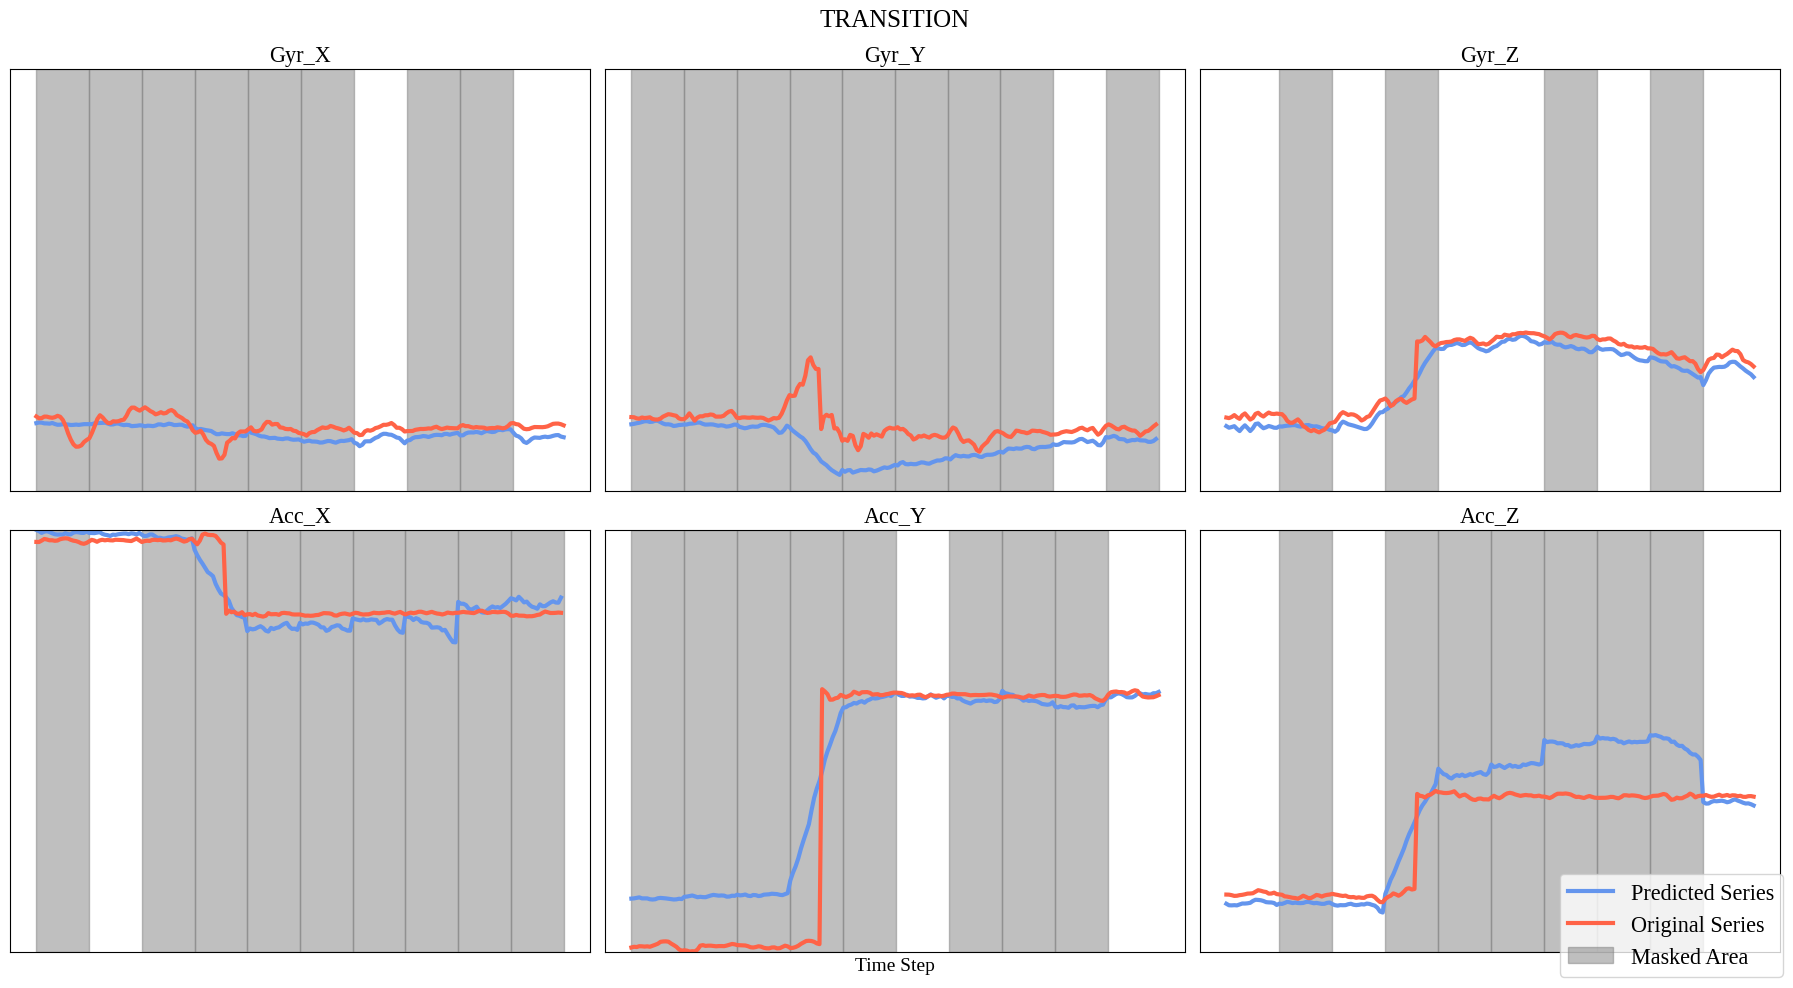

Processing WALKING at index 9, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


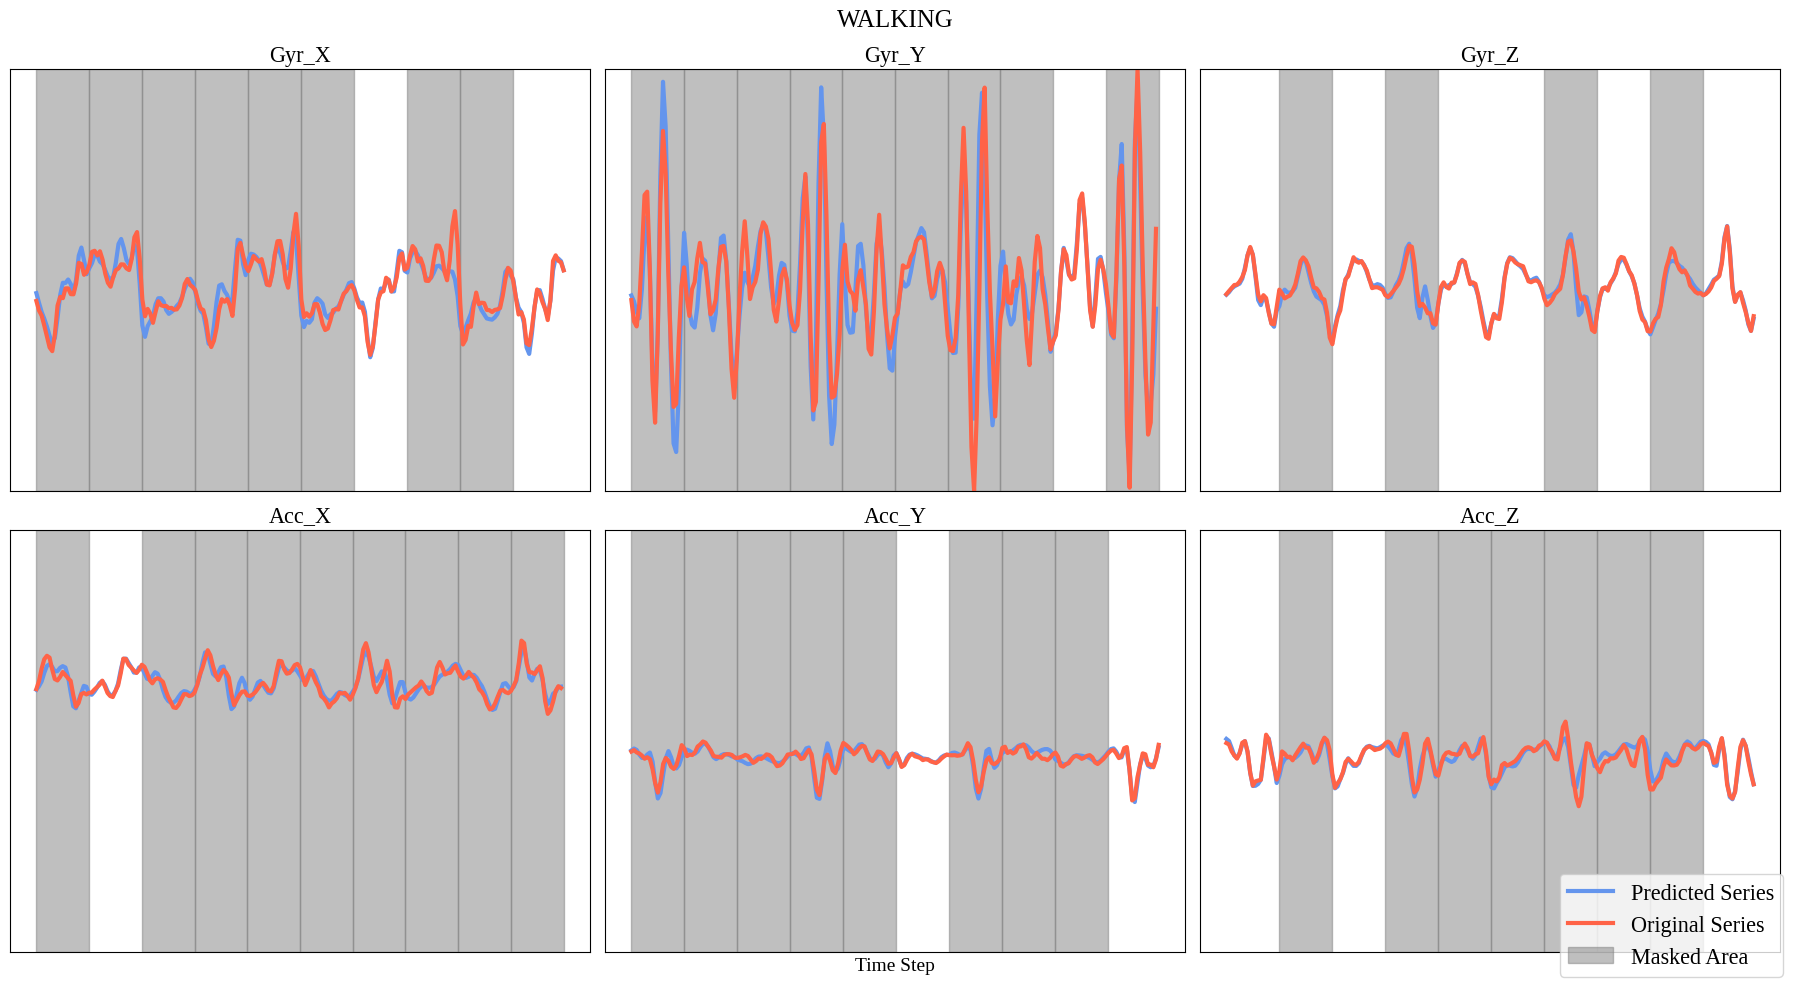

Processing WALKING-DOWN at index 19, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


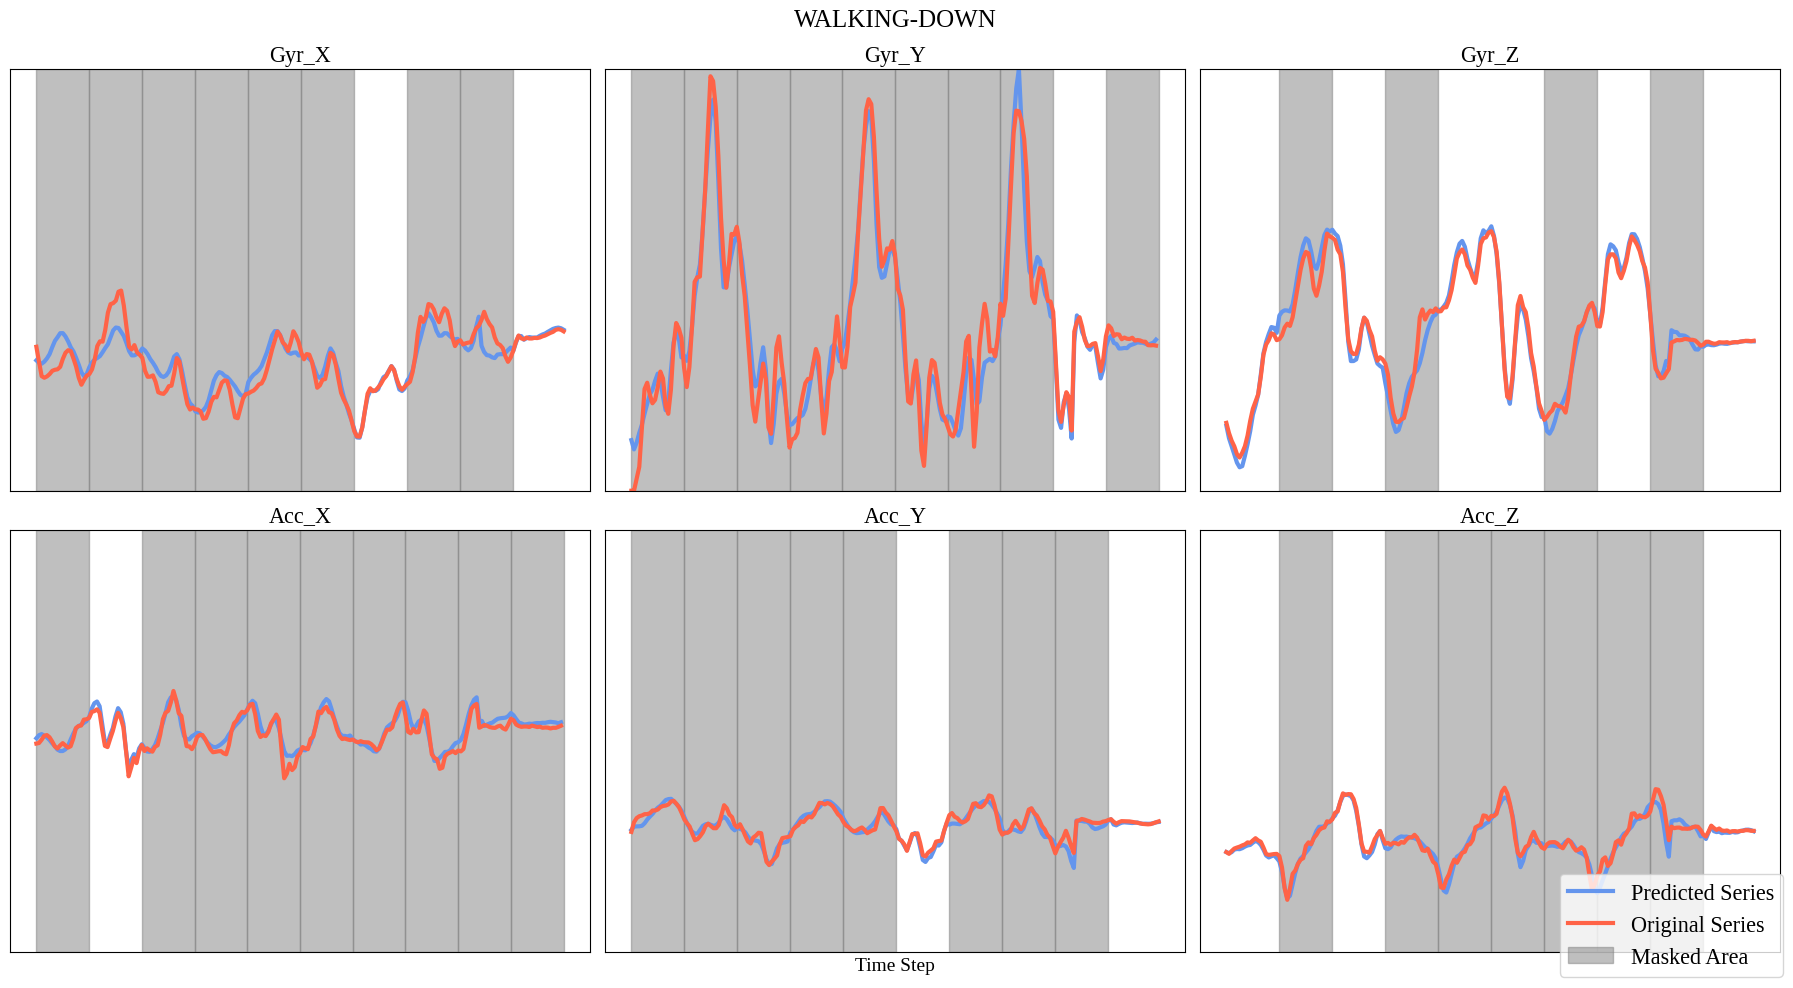

Processing WALKING-UP at index 18, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


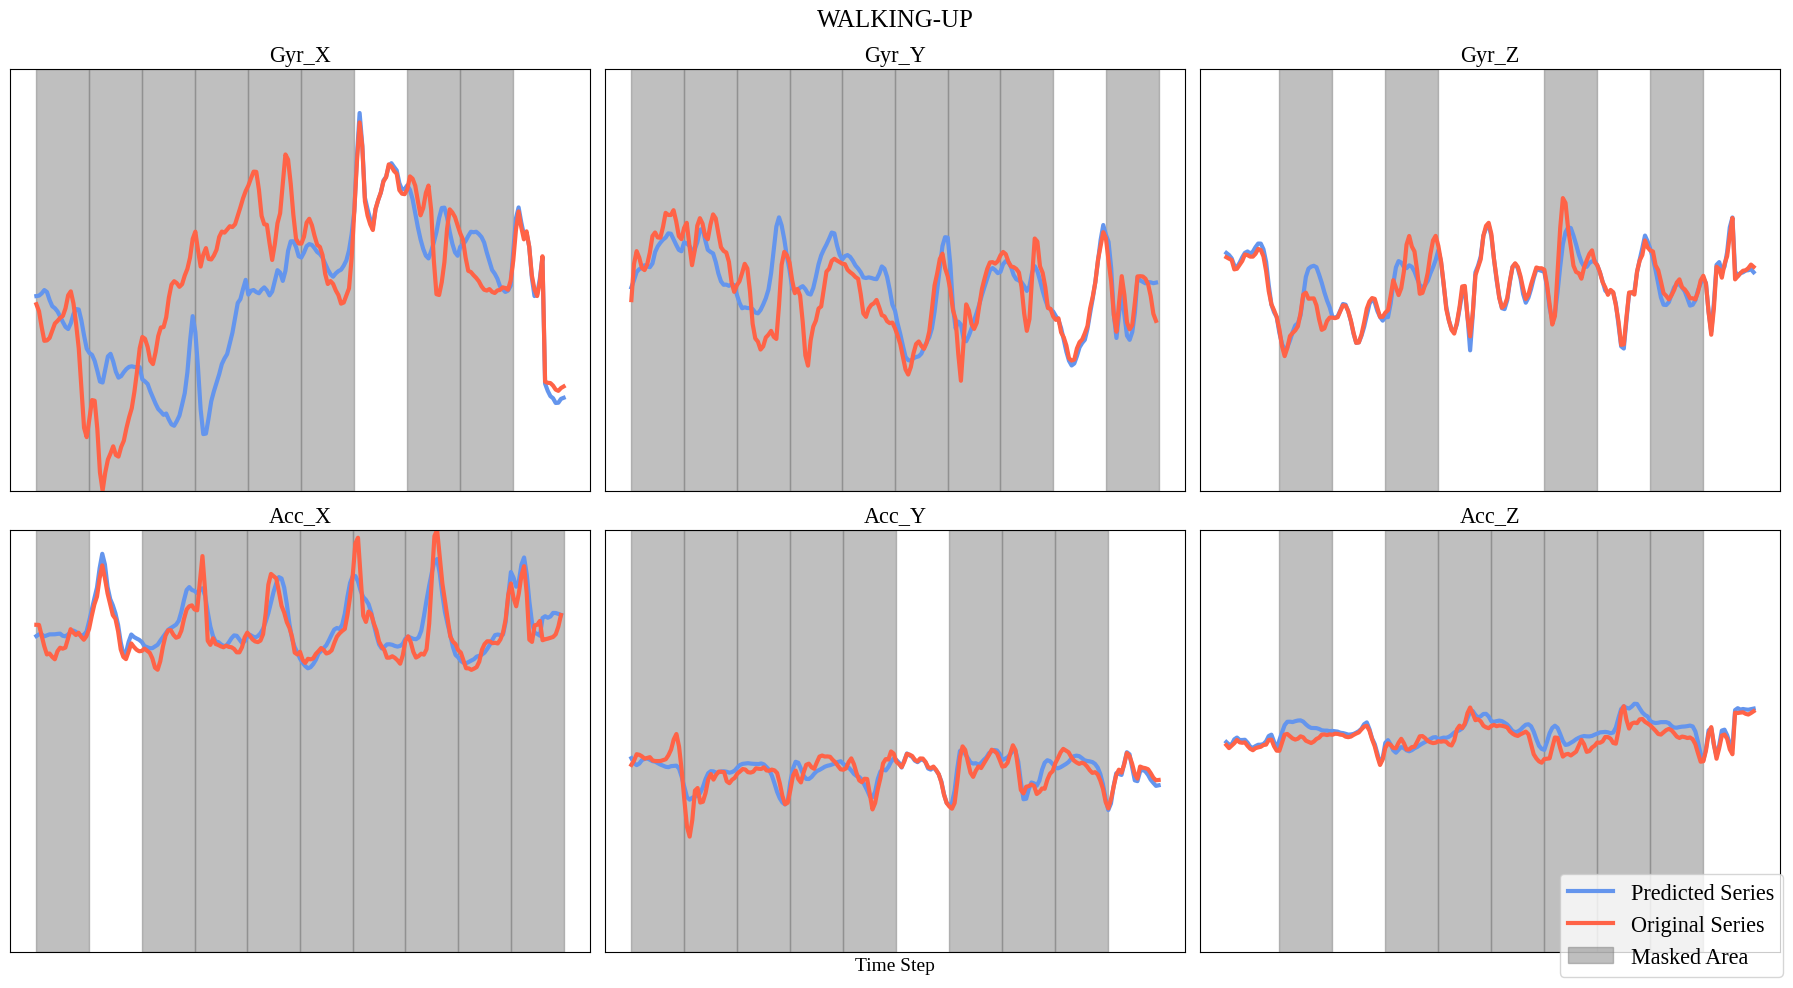

Processing SITTING at index 2, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


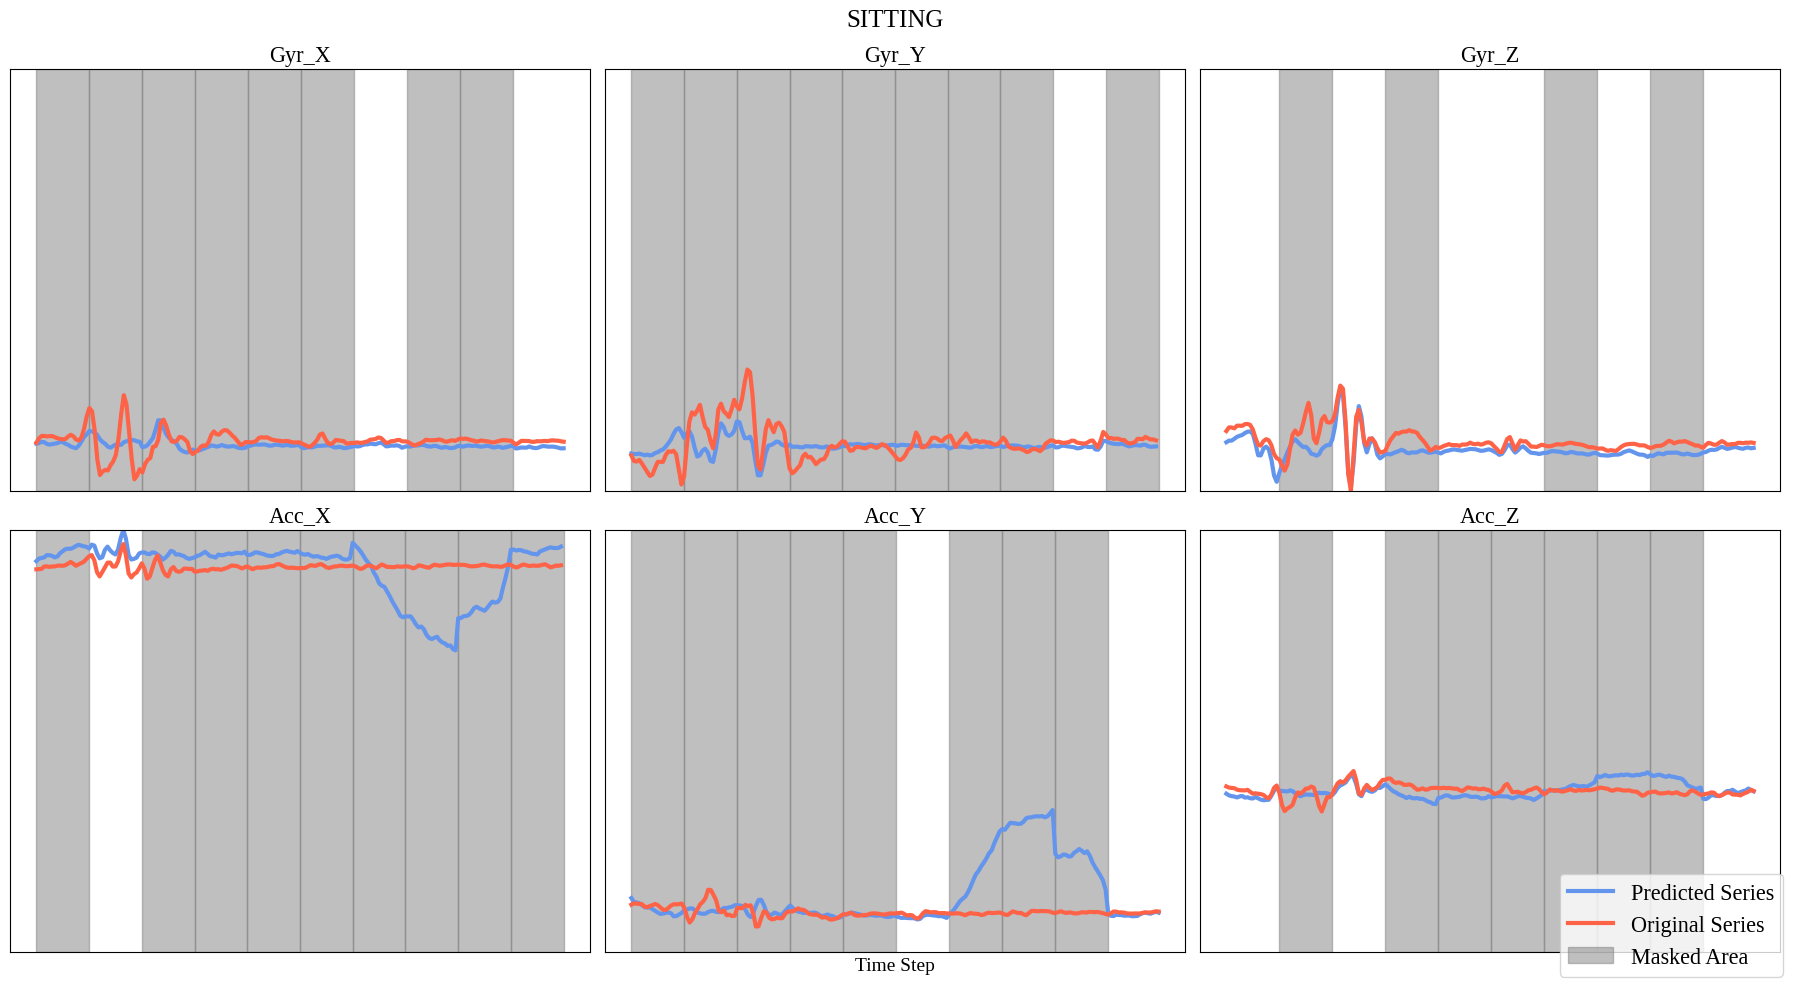

Processing STANDING at index 1, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


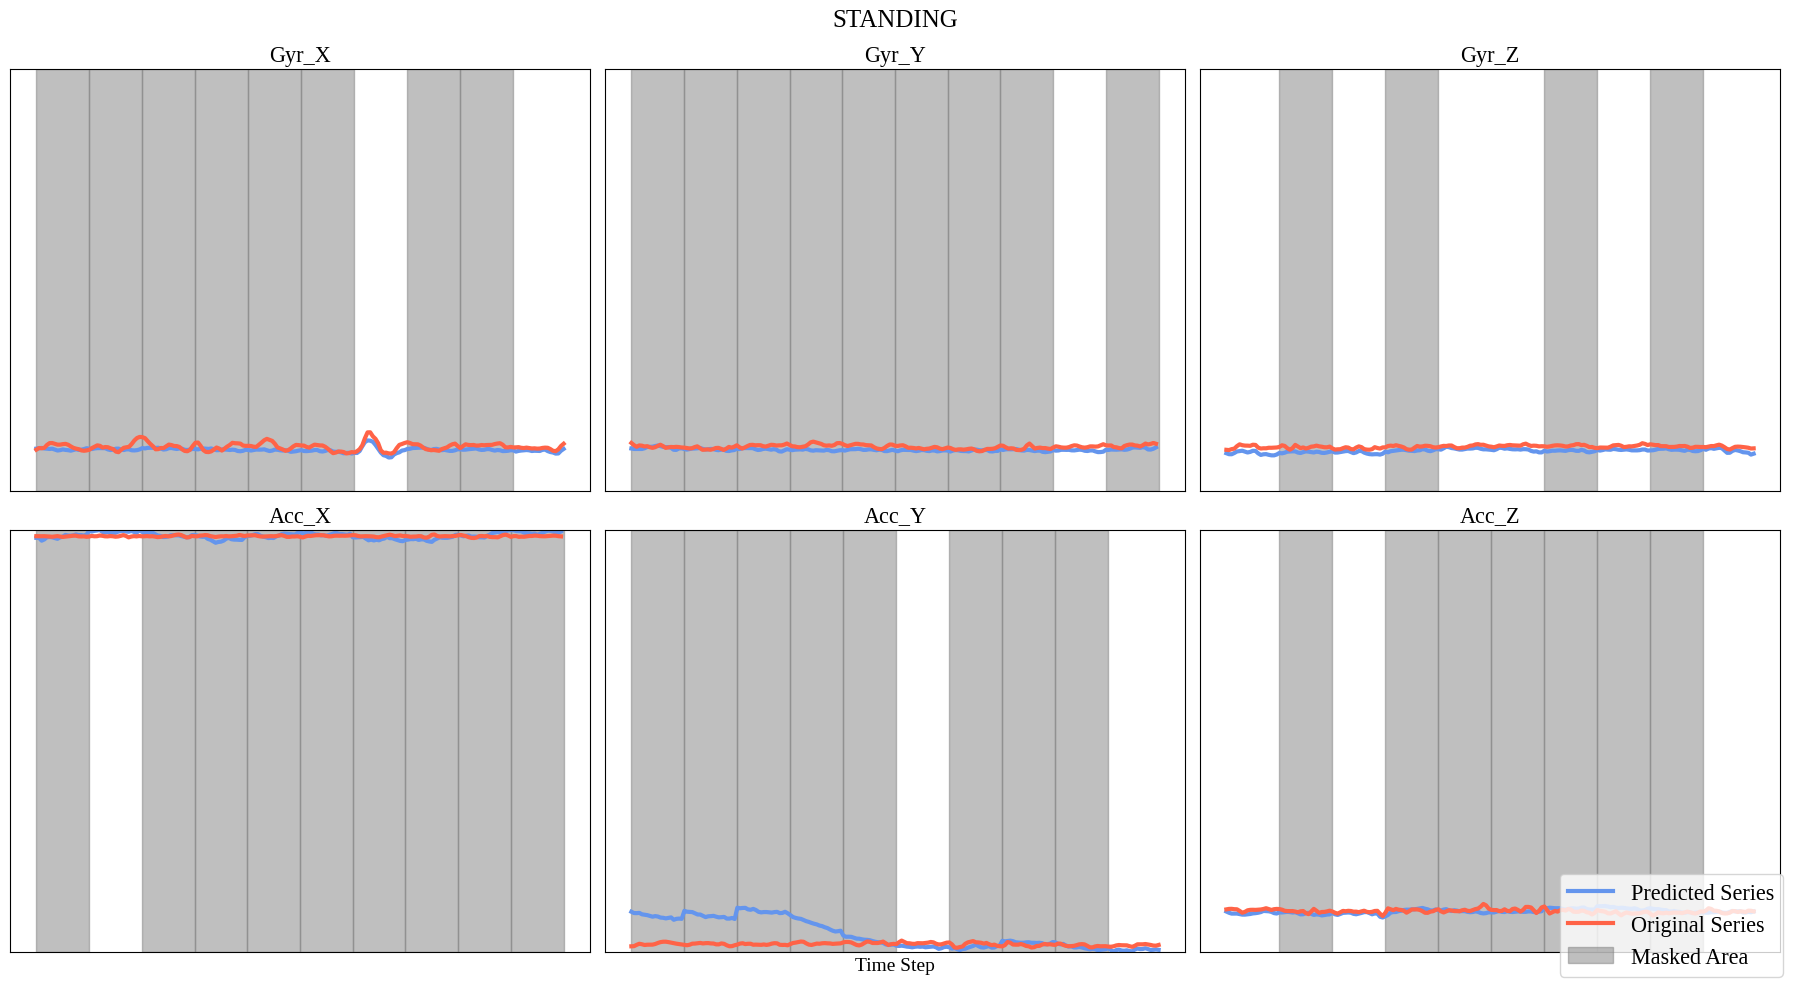

Processing LAYING at index 0, shape: torch.Size([1, 1, 6, 200])
mask_np (6, 10)
predict_series (6, 200)
target_series (6, 200)


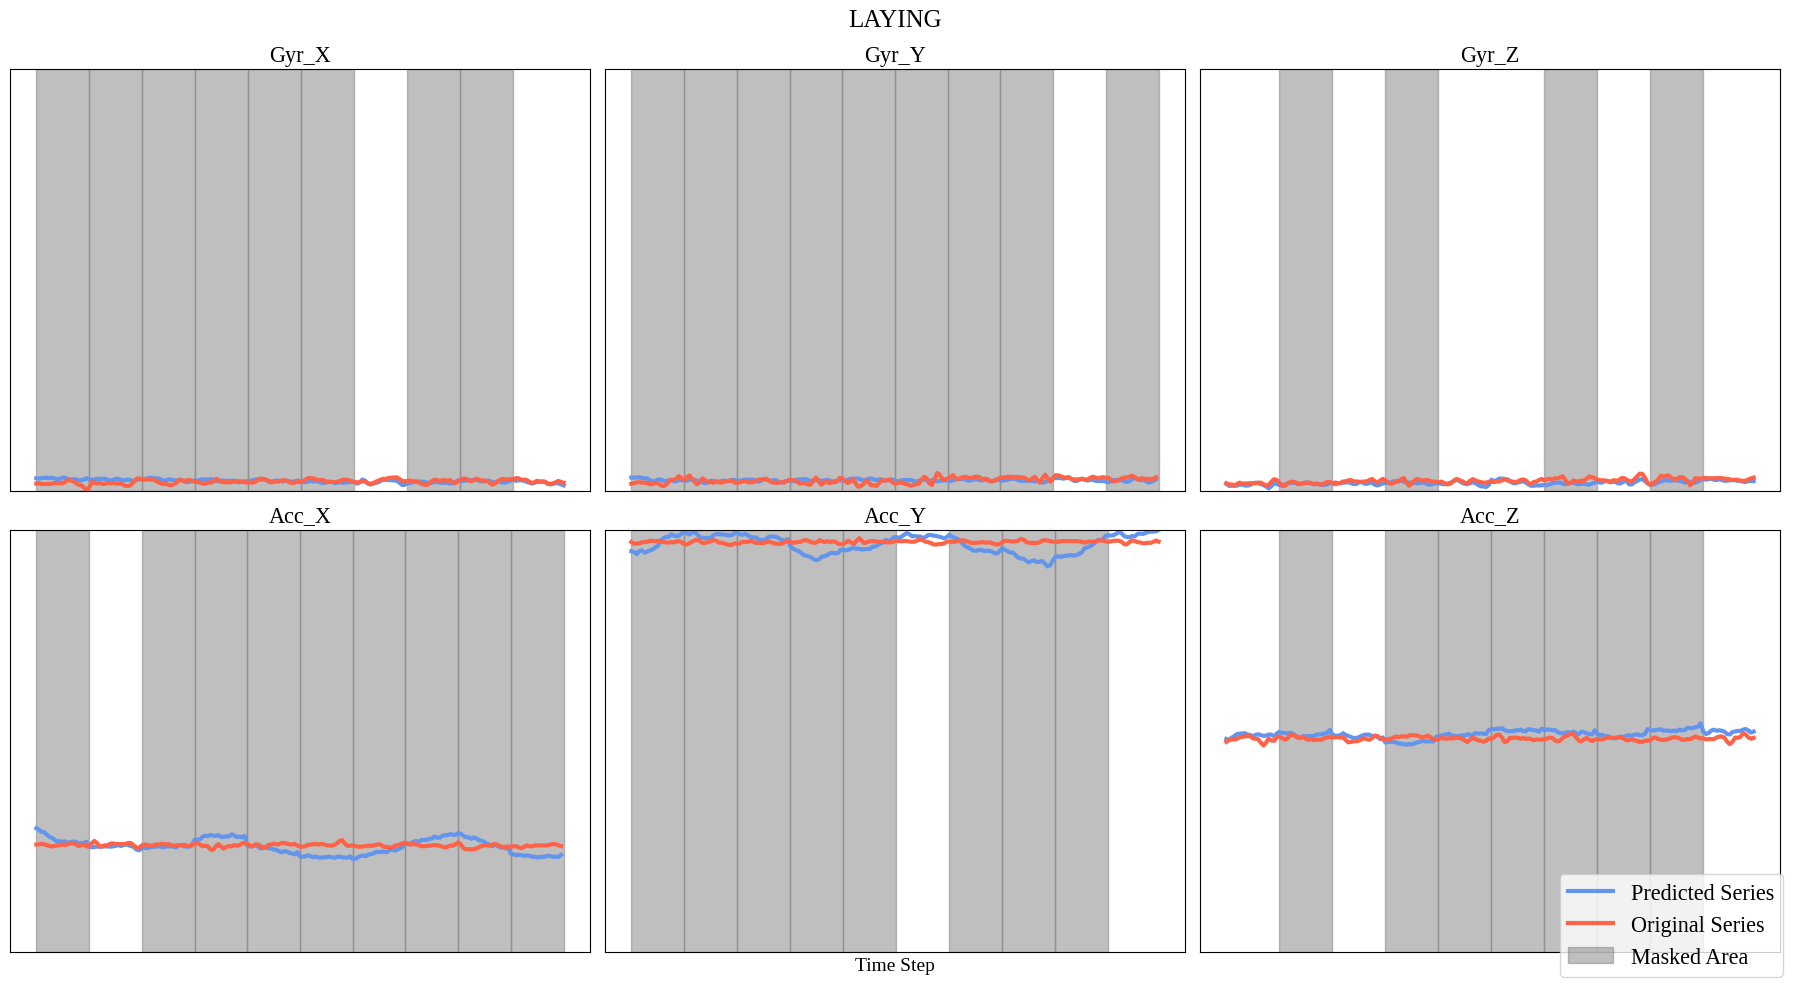

In [ ]:
sample_indices = {
    "TRANSITION": 6,
    "WALKING": 9,
    "WALKING-DOWN": 19,
    "WALKING-UP": 18,
    "SITTING": 2,
    "STANDING": 1,
    "LAYING": 0
}

for activity, index in sample_indices.items():
    torch.manual_seed(42)
    # Extract the sample based on the index and remove the batch dimension
    sample = test_seq[index:index + 1]
    print(f"Processing {activity} at index {index}, shape: {sample.shape}")
    
    with torch.no_grad():
        cross_6_200_loss, cross_6_200_pred, cross_6_200_mask = cross_6_200_model(sample,mask_ratio=0.75)
        cross_6_200_pred = cross_6_200_model.unpatchify(cross_6_200_pred)
        plot_masked_series(cross_6_200_mask.reshape(shape=(6,10)),cross_6_200_pred.squeeze(0),
                           sample.squeeze(0),
                            title = activity)
    
    

# T-SNE

In [ ]:
from util.datasets import UCIHAR
dataset_train = UCIHAR(data_path='data/200', is_test=False,mix_up=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True,mix_up=False)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

# Define the activity labels
activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}

def get_tsne(model, dataloader, n_components=2, perplexity=30, learning_rate=200):
    model.eval()
    features = []
    labels = []

    model = model.to('cuda')
    with torch.no_grad():
        for i, (x, label) in enumerate(tqdm(dataloader)):
            x = x.to('cuda') # x:[bs,1,6, 200]
            # # For early fusion
            x = x.permute(0, 2, 1, 3) #need to be bs, 6, 1, 200
            #####################

            # Extract features from the model (assuming model returns features)
            feature, _, _ = model.forward_encoder(x, mask_ratio=0)  # bs x nvar*num_p+1 x E
      
            bs, _, E = feature.shape
            # use cls token as presentation
            feature = feature[:,0,:]

            features.append(feature.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Flatten lists
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate,
                n_iter=2000,init='pca')
    pca = PCA(n_components=50)
    features = pca.fit_transform(features) # Apply PCA First
    print(features.shape)
    tsne_results = tsne.fit_transform(features)

    return tsne_results, labels

def plot_tsne(tsne_results, labels, activity_labels):
    # Define a colormap with 7 distinct colors
    cmap = ListedColormap(plt.cm.tab10.colors[:7])

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.7)
    
    # Create a colorbar with activity names
    # cbar = plt.colorbar(scatter, ticks=np.arange(7))
    # cbar.set_label('Activity')
    # cbar.set_ticklabels([activity_labels[i] for i in range(7)])  # Use activity names for ticks
    
    plt.title('t-SNE of Model Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()




100%|██████████| 29/29 [00:02<00:00, 11.29it/s]


(1847, 50)


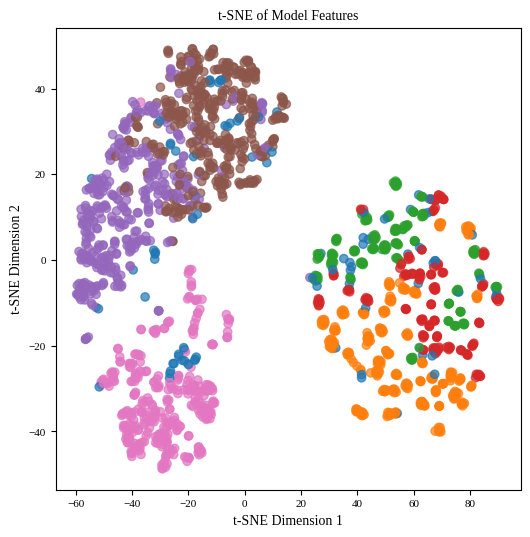

In [ ]:

# Example usage:
tsne_results, labels = get_tsne(cross_6_200_model, data_loader_train)
plot_tsne(tsne_results, labels, activity_labels)

Plot syncronize masking

In [ ]:
sync_6_200_model = MaskedAutoencoderViT(
    img_size=[6, int(200)],
    patch_size=[1, int(20)],
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
)


sync_6_200_model_checkpoint = torch.load('/home/jovyan/persistent-data/leo/output_dir/syncmask_8_checkpoint-200.pth',map_location='cpu')
msg = sync_6_200_model.load_state_dict(sync_6_200_model_checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


100%|██████████| 29/29 [00:02<00:00, 11.87it/s]


(1847, 50)


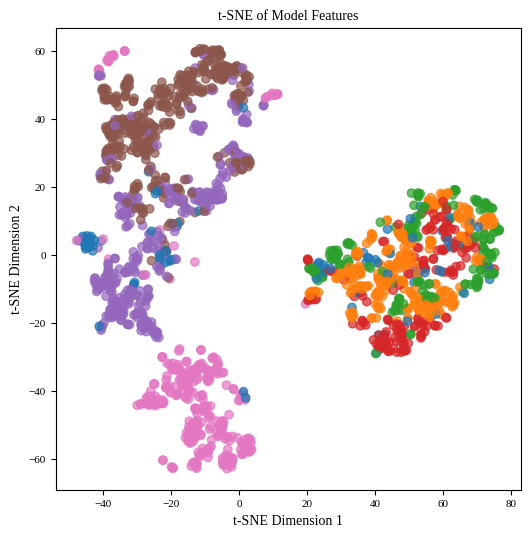

In [ ]:
sync_tsne_results, sync_labels = get_tsne(sync_6_200_model, data_loader_train)
plot_tsne(sync_tsne_results, sync_labels, activity_labels)

Plot Early Fusion

In [ ]:
mix_model = MaskedAutoencoderViT(
    img_size=[1, int(200)],
    patch_size=[1, int(20)],
    in_chans=6,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
)


mix_model_checkpoint = torch.load('/home/jovyan/persistent-data/MAE_Accelerometer/experiments/56(p200_10_alt_0.0005)/checkpoint-3999.pth',map_location='cpu')
msg = mix_model.load_state_dict(mix_model_checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


100%|██████████| 29/29 [00:01<00:00, 20.63it/s]


(1847, 50)


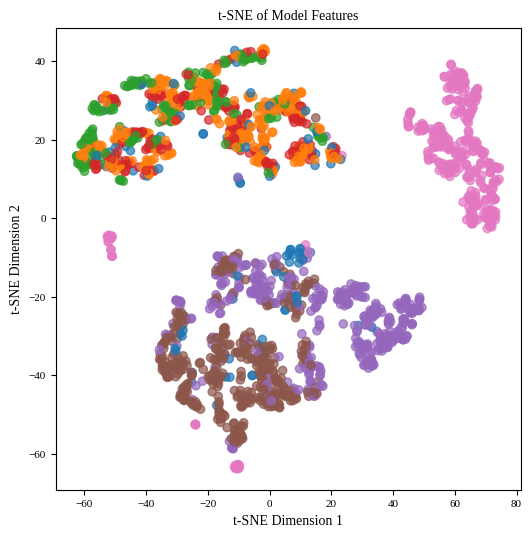

In [ ]:
mix_tsne_results, mix_labels = get_tsne(mix_model, data_loader_train)
plot_tsne(mix_tsne_results, mix_labels, activity_labels)

# Confusion Matrix

## ViT Baseline Eval

In [ ]:
## Confusion Matrix for MAE Pre-Trained Baseline
#from leo_model_mae import MaskedAutoencoderViT
from torchvision.models import vit_b_16 
import timm
import torch
#from vit import LinearProb
from vit_baseline import LinearProbWrapper
import torch.nn as nn

backbone = vit_b_16(pretrained=False)

backbone.heads = nn.Linear(768,7,bias=True)
model = LinearProbWrapper(backbone)
checkpoint = torch.load('../../../data/leo/downstream/output_dir/vit_baseline_linprob_ucihar_7_checkpoint-49.pth',map_location='cpu')

checkpoint_model = checkpoint['model']
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


In [ ]:
from util.datasets import UCIHAR

dataset_train = UCIHAR(data_path='data/200', is_test=False,mix_up=False,transform=True)
dataset_val = UCIHAR(data_path='data/200',is_test=True,mix_up=False,transform=True)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

In [ ]:
from itertools import chain
from tqdm import tqdm
import numpy as np

def mae_classification_pass(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('using ',device)
    # initialize for loop
    preds = list()
    targets = list()
    for batch in tqdm(data_loader):
        images = batch[0].to(device)
        target = batch[-1].to(device)
     
        output = model(images,mask_ratio=0)
        print(output.shape)
        #print(output)
        pred = torch.argmax(output, dim=1)

        #images_for_plot = torch.einsum('nchw -> nhwc', images)
        #plt.plot(images_for_plot[0,0,:,3], label="x")
        #plt.plot(np.repeat(target, 200), label="target")
        #plt.plot(np.repeat(pred, 200), label="pred")
        #plt.show()

        preds.append(pred.cpu().numpy())
        targets.append(target.cpu().numpy())

    #print("image shape:", images.shape, "target shape:", target.shape, "output shape:", output.shape)
    #print("target:", target, "pred:", pred)

    #acc1, acc3 = accuracy(output, target, topk=(1, 3)) 
    #print("acc1, acc3:", acc1, acc3)
    preds_list = list(chain(*preds))
    targets_list = list(chain(*targets))
    accordance = np.array(preds_list) == np.array(targets_list)
    accuracy = np.sum(accordance)/len(preds_list)

    return preds_list, targets_list, accuracy

using  cuda


  0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([64, 7])


  8%|▊         | 1/13 [00:00<00:09,  1.20it/s]

torch.Size([64, 7])


 15%|█▌        | 2/13 [00:01<00:06,  1.77it/s]

torch.Size([64, 7])


 23%|██▎       | 3/13 [00:01<00:05,  1.98it/s]

torch.Size([64, 7])


 31%|███       | 4/13 [00:02<00:04,  2.17it/s]

torch.Size([64, 7])


 38%|███▊      | 5/13 [00:02<00:03,  2.23it/s]

torch.Size([64, 7])


 46%|████▌     | 6/13 [00:02<00:03,  2.31it/s]

torch.Size([64, 7])


 54%|█████▍    | 7/13 [00:03<00:02,  2.34it/s]

torch.Size([64, 7])


 62%|██████▏   | 8/13 [00:03<00:02,  2.37it/s]

torch.Size([64, 7])


 69%|██████▉   | 9/13 [00:04<00:01,  2.42it/s]

torch.Size([64, 7])


 77%|███████▋  | 10/13 [00:04<00:01,  2.41it/s]

torch.Size([64, 7])


 85%|████████▍ | 11/13 [00:04<00:00,  2.44it/s]

torch.Size([64, 7])


100%|██████████| 13/13 [00:05<00:00,  2.98it/s]

torch.Size([25, 7])


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


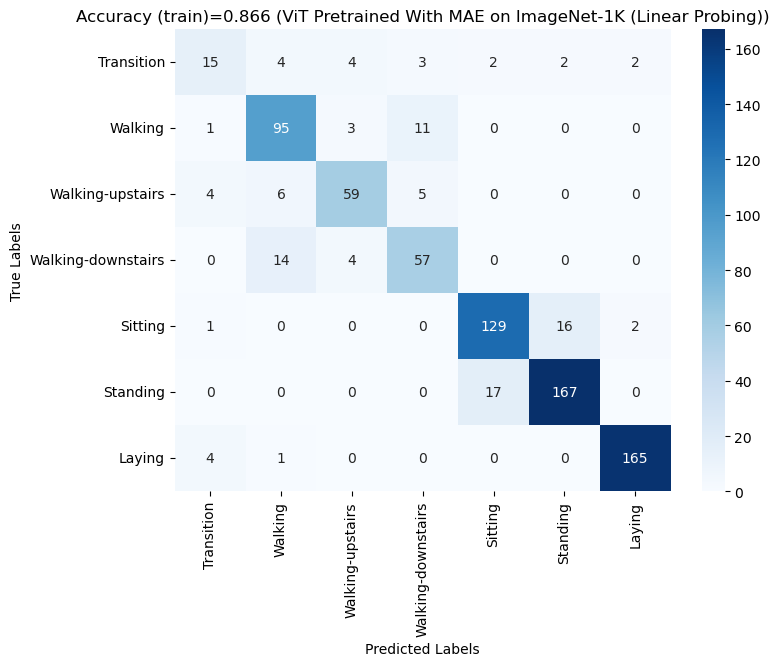

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred_all, target_all, accuracy_all = mae_classification_pass(data_loader_val,model)
trial_classification = 'ViT Pretrained With MAE on ImageNet-1K (Linear Probing)'

cm_all = confusion_matrix(target_all, pred_all)

#labels = ['Transition', 'Walking', 'Sitting', 'Standing', 'Laying']
labels = ['Transition', 'Walking', 'Walking-upstairs', 'Walking-downstairs', 'Sitting', 'Standing', 'Laying']

plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, cmap='Blues', fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Accuracy (train)={round(accuracy_all,3)} ({trial_classification})')
plt.show()



## Our MAE

In [ ]:
dataset_train = UCIHAR(data_path='data/200', is_test=False,mix_up=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True,mix_up=False)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

<All keys matched successfully>
using  cuda


 15%|█▌        | 2/13 [00:00<00:02,  4.28it/s]

torch.Size([64, 7])
torch.Size([64, 7])
torch.Size([64, 7])


 31%|███       | 4/13 [00:00<00:01,  6.62it/s]

torch.Size([64, 7])
torch.Size([64, 7])


 46%|████▌     | 6/13 [00:00<00:00,  7.83it/s]

torch.Size([64, 7])
torch.Size([64, 7])


 62%|██████▏   | 8/13 [00:01<00:00,  7.66it/s]

torch.Size([64, 7])
torch.Size([64, 7])


 77%|███████▋  | 10/13 [00:01<00:00,  8.17it/s]

torch.Size([64, 7])
torch.Size([64, 7])


 92%|█████████▏| 12/13 [00:01<00:00,  8.57it/s]

torch.Size([64, 7])
torch.Size([25, 7])


100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


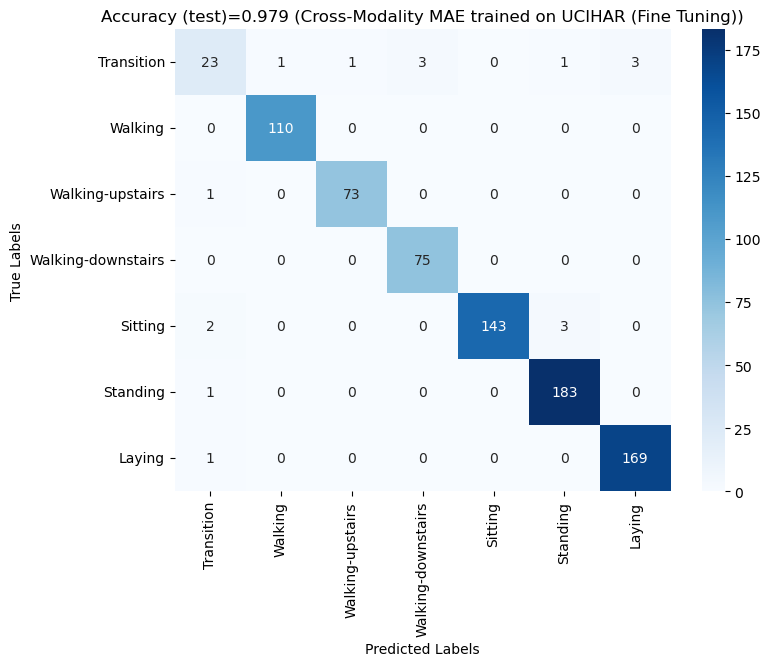

In [ ]:
from main_linprobe import LinearProb

trial_classification = 'Cross-Modality MAE trained on UCIHAR (Fine Tuning)'
inf_model = LinearProb(cross_6_200_model) # just a wrapper
inf_model_checkpoint = torch.load('../../../data/leo/downstream/output_dir/cross_mae_finetune_ucihar_7_checkpoint-best.pth',map_location='cpu')
msg = inf_model.load_state_dict(inf_model_checkpoint['model'], strict=False)
print(msg)

pred_test, target_test, accuracy_test = mae_classification_pass(data_loader_val,inf_model)
cm_test = confusion_matrix(target_test, pred_test)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Accuracy (test)={round(accuracy_test,3)} ({trial_classification})')
plt.show()

# Downstream Attention

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors for attention maps


def show_attention_map(attn_map, checkpoint_name):
    # Ensure the attention map is a numpy array
    attn_map = attn_map.numpy() if isinstance(attn_map, torch.Tensor) else attn_map

    num_patches = int(10 * (1 - MASK_RATIO))
    num_variates = (attn_map.shape[0]-1)//num_patches  # Number of variates (e.g., 6 for Gyr_X, Gyr_Y, etc.)

    # Define labels for x and y axes
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]

    # Adjust x_labels and y_labels for the CLS token and patches
    x_labels = ['CLS'] + [f'{variate_labels[i]}_{j}' for i in range(num_variates) for j in range(num_patches)]
    y_labels = x_labels

    # Plot attention map
    plt.figure(figsize=(10, 10))  # Adjust size as needed
    plt.imshow(attn_map, cmap='Blues', interpolation='nearest')
    plt.colorbar()  # Add a color bar to show the scale
    plt.title(checkpoint_name + ' Attention Map')

    # Set x and y axis labels
    plt.xticks(ticks=np.arange(num_patches * num_variates+1), labels=x_labels, rotation=90, fontsize=8)
    plt.yticks(ticks=np.arange(num_patches * num_variates+1), labels=y_labels, fontsize=8)
    
    # Optionally hide the axes if needed
    plt.axis('on')  # Change to 'off' if you prefer to hide the axes
    
    plt.show()


def show_reduced_attention_map(attn_map, checkpoint_name):
    num_patches_per_variate = int(10 * (1 - MASK_RATIO))
    num_variates = (attn_map.shape[0]-1)//num_patches_per_variate

    # Initialize an empty tensor to store the reduced attention map
    reduced_attn_map = torch.zeros(num_variates, num_variates)

    # Compute the mean for each variate
    for i in range(num_variates):
        for j in range(num_variates):
            start_i = i * num_patches_per_variate
            end_i = start_i + num_patches_per_variate
            start_j = j * num_patches_per_variate
            end_j = start_j + num_patches_per_variate

            # Take the mean of the corresponding patches
            reduced_attn_map[i, j] = attn_map[start_i:end_i, start_j:end_j].mean()

    # Labels for the variates
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]

    # Plot reduced attention map
    plt.figure(figsize=(8, 8))  # Adjust size as needed
    im = plt.imshow(reduced_attn_map, cmap='Blues', interpolation='nearest')
    plt.colorbar()  # Add a color bar to show the scale
    plt.title(checkpoint_name + ' Reduced Attention Map')
    
    # Set x and y axis labels
    plt.xticks(ticks=np.arange(num_variates), labels=variate_labels, rotation=90, fontsize=10)
    plt.yticks(ticks=np.arange(num_variates), labels=variate_labels, fontsize=10)
    
    # Add gridlines for better visualization if needed
    # plt.grid(visible=True, which='both', axis='both', linestyle='--', color='gray', alpha=1)
    
    # Highlight major ticks
    plt.tick_params(axis='x', which='major', length=10, width=1)
    plt.tick_params(axis='y', which='major', length=10, width=1)

    plt.show()


In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

MASK_RATIO = 0
DEVICE = 'cuda'

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        #print('input shape:',x.shape)
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        #attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward



In [ ]:
from util.datasets import UCIHAR

dataset_train = UCIHAR(data_path='data/200', is_test=False,mix_up=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True,mix_up=False)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

In [ ]:
from main_linprobe import LinearProb

backbone = MaskedAutoencoderViT(
    img_size=[6, int(200)],
    patch_size=[1, int(20)],
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
)

model = LinearProb(cross_6_200_model) # just a wrapper
inf_model_checkpoint = torch.load('../../../data/leo/downstream/output_dir/cross_mae_finetune_ucihar_7_checkpoint-best.pth',map_location='cpu')
msg = model.load_state_dict(inf_model_checkpoint['model'], strict=False)
print(msg)

print(model.backbone.blocks[-1].attn)
model.backbone.blocks[-1].attn.forward = my_forward_wrapper(model.backbone.blocks[-1].attn)

In [12]:
# test sample slice # for TRANSITION(0): 6 ;
image_length = 200

test_seq_y = torch.Tensor(torch.load(f'data/{image_length}/y_test_all_mode.pt'))
                          
activity_labels = {0: "TRANSITION", 1: "WALKING", 2: "WALKING-DOWN", 3: "WALKING-UP", 4: "SITTING", 5: "STANDING", 6: "LAYING"}
for i, activity in enumerate(activity_labels.values()):
    print(f"test sample slice # for {activity}({i}):", np.where(test_seq_y == i)[0][0],";")

test_seq = torch.Tensor(torch.load(f'data/{image_length}/X_test_all.pt')).permute(0, 1, 3, 2)
print(test_seq.shape)

test sample slice # for TRANSITION(0): 6 ;
test sample slice # for WALKING(1): 9 ;
test sample slice # for WALKING-DOWN(2): 19 ;
test sample slice # for WALKING-UP(3): 18 ;
test sample slice # for SITTING(4): 2 ;
test sample slice # for STANDING(5): 1 ;
test sample slice # for LAYING(6): 0 ;
torch.Size([793, 1, 6, 200])


In [13]:
def get_sample(model, test_seq, test_seq_y, 
               index, layer=-1, mask_ratio=0, num_variates=6):
    # Extract and process the sample sequence
    sample = test_seq[index:index+1].to(DEVICE)
    model.to(DEVICE)
    print(f"Sample shape: {sample.shape}")
    print(f"Ground truth: {test_seq_y[index:index+1]}")

    # Pass the sample through the model
    with torch.no_grad():
        y = model(sample)#, mask_ratio=mask_ratio)
    
    #######################
    predicted_class = torch.argmax(y, dim=-1)  # Adjust the dimension as needed
    # Print the ground truth and prediction
    print(f"Prediction: {predicted_class}")
    # Check if the prediction matches the ground truth
    if predicted_class.item() == test_seq_y[index].item():  # Assuming test_seq_y[index] is a scalar
        print("The prediction is correct!")
    else:
        print("The prediction is incorrect.")
    #######################
    
    # Get attention maps
    print(f'Attention Map for layer {layer}')
    attn_map = model.blocks[layer].attn.attn_map.sum(dim=1).squeeze(0).detach()  # Average all heads
    print(f"Attention map shape: {attn_map.shape}")

    # Calculate number of patches
    num_patches = int(10 * (1 - mask_ratio)) + 1

    # TODO: Get the Attention Map of the CLS token attending to each patches token
    attn_map_cls = attn_map[0].unsqueeze(0)  # Shape: (1, num_patches)
    #attn_map_cls = attn_map[:,0].unsqueeze(0)

    print(f"CLS token attention map to patches shape: {attn_map_cls.shape}")

    return sample,attn_map,attn_map_cls


In [ ]:
# # Example usage:
# index = 5
# with torch.no_grad():
#     transition_sample, transition_attn_map, transition_cls_attn_map,transition_cls_token_indices = get_sample(model, test_seq, test_seq_y, index, mask_ratio=0)

# show_attention_map(transition_attn_map.cpu(),checkpoint_name='cross_mae_finetune_ucihar_7_checkpoint')
# show_reduced_attention_map(transition_attn_map.cpu(),checkpoint_name='cross_mae_finetune_ucihar_7_checkpoint')

In [14]:
index = 5
with torch.no_grad():
    transition_sample, transition_attn_map, transition_cls_attn_map = get_sample(model, test_seq, test_seq_y, index, mask_ratio=0)

Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([6.])
Prediction: tensor([6], device='cuda:0')
The prediction is correct!
Attention Map for layer -1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])


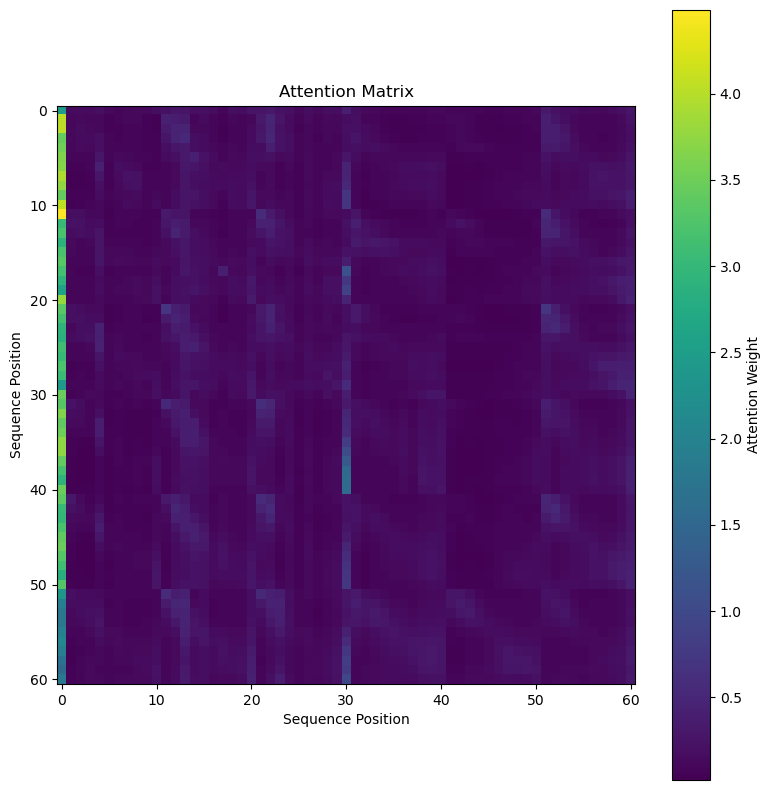

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example attention matrix (replace this with your actual data)
# transition_attn_map = np.random.rand(61, 61)

# Plotting the attention matrix
plt.figure(figsize=(8, 8))
plt.imshow(transition_attn_map.cpu(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Attention Weight')
plt.title('Attention Matrix')
plt.xlabel('Sequence Position')
plt.ylabel('Sequence Position')
plt.xticks(range(0, 61, 10))
plt.yticks(range(0, 61, 10))
plt.grid(False)  # Set to True if gridlines are desired
plt.tight_layout()

# Save the plot (optional)
# plt.savefig("attention_matrix.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
def aggregate_attention(attn_map_cls_to_patches, num_variates=6, num_patches_per_variate=10):
    # Check if the shape is correct
    assert attn_map_cls_to_patches.shape[1] == num_variates * num_patches_per_variate, \
        f"Expected attention map shape: [1, {num_variates * num_patches_per_variate}], got: {attn_map_cls_to_patches.shape}"

    # Reshape to [1, num_variates, num_patches_per_variate]
    attn_map_reshaped = attn_map_cls_to_patches.view(1, num_variates, num_patches_per_variate)

    # Aggregate attention for each variate (you can use mean or sum as per your requirement)
    attn_per_variate = attn_map_reshaped.sum(dim=2)  # Shape: [1, num_variates]

    return attn_per_variate

def plot_feature_diversity(feature_diversity):
    # Convert feature diversity to a NumPy array for plotting
    feature_diversity_np = feature_diversity.squeeze().cpu().numpy()  # Shape: [num_variates]
    # Apply Z-score normalization: (x - mean) / std
    feature_diversity_np = feature_diversity_np / feature_diversity_np.sum()
    # Create a heatmap with subtle variations, using a neutral colormap
    plt.figure(figsize=(8, 4))
    plt.imshow(feature_diversity_np.reshape(1, -1), cmap='viridis', interpolation='nearest')

    # Set color bar
    plt.colorbar(label='Normalized Contribution')

    # Set ticks and labels
    plt.xticks(np.arange(len(feature_diversity_np)), ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"])
    plt.yticks([])  # Hide y ticks since it's a single row

    plt.title('Feature Diversity: Equal Contribution per Variate')
    plt.xlabel('Variates')
    plt.grid(False)
    plt.show()





In [ ]:
# # Example usage
# feature_diversity = aggregate_attention(transition_cls_attn_map[:, 1:])
# print(feature_diversity)
# plot_feature_diversity(feature_diversity)

### Global Pooling

In [9]:
from util.datasets import UCIHAR

dataset_train = UCIHAR(data_path='data/200', is_test=False)
dataset_val = UCIHAR(data_path='data/200',is_test=True)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

data_loader_val = torch.utils.data.DataLoader(
        dataset_val, shuffle=False,
        batch_size=64,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

In [ ]:
from tqdm import tqdm

model = model.to(DEVICE)

attn_map_list = []
for x,_ in tqdm(data_loader_train):
    x = x.to(DEVICE)
    y = model(x,mask_ratio=MASK_RATIO)
    
    attn_map = model.backbone.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach() # average all heads
    attn_map_list.append(attn_map)

attn_map_all_batch = torch.cat(attn_map_list, dim=0)
print(attn_map_all_batch.shape)
attn_map = attn_map_all_batch.mean(dim=0)
print(attn_map.shape)


100%|██████████| 29/29 [00:04<00:00,  6.65it/s]

torch.Size([1847, 61, 61])
torch.Size([61, 61])


In [ ]:
feature_diversity = aggregate_attention(attn_map[0:1][:,1:])
feature_diversity / feature_diversity.sum()
print(feature_diversity)
plot_feature_diversity(feature_diversity)


# HeatMap Downstream Attention

In [5]:
from main_linprobe import LinearProb
from models_mae import MaskedAutoencoderViT
from models_vit import *
# model = MaskedAutoencoderViT(
#     img_size=[6, int(200)],
#     patch_size=[1, int(20)],
#     in_chans=1,
#     embed_dim=768,
#     depth=12,
#     num_heads=12,
#     decoder_embed_dim=512,
#     decoder_depth=8,
#     decoder_num_heads=16,
#     mlp_ratio=4,
# )

model = VisionTransformer(
        img_size = [6,200],patch_size=[1,20], 
        embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, 
        qkv_bias=True,in_chans=1, num_classes=7,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),)

#model = LinearProb(backbone) # just a wrapper
#inf_model_checkpoint = torch.load('/home/jovyan/MAE_Accelerometer/results/cross_mae_finetune_ucihar_7_checkpoint-best.pth',map_location='cpu')
inf_model_checkpoint = torch.load('/home/jovyan/persistent-data/leo/optim_mask/downstream/ckpt/MoCA_20pth_ucihar_7_finetune/2025-03-25_00-35/MoCA_20pth_ucihar_7_finetune_checkpoint-49.pth',map_location='cpu')
msg = model.load_state_dict(inf_model_checkpoint['model'], strict=False)
print(msg)

print(model.blocks[-1].attn)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

<All keys matched successfully>
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import os

def preprocess_data(transition_sample, transition_cls_attn_map, cls_token_indices):
    
    time_series_data = transition_sample.squeeze().cpu()  # Shape: (6, 200)
    transition_cls_attn_map = transition_cls_attn_map[:,1:] # 1, 60, ignore self cls token
    transition_cls_attn_map = transition_cls_attn_map.reshape(6,-1)  # (1,60) -> (6,10)

    print('attention map to plot: ',transition_cls_attn_map.shape)
    return time_series_data, transition_cls_attn_map

def plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity, num_patches=10, save_dir=None):
    variate_labels = ["Gyr_X", "Gyr_Y", "Gyr_Z", "Acc_X", "Acc_Y", "Acc_Z"]
    cmap = plt.get_cmap('YlOrRd')  # Yellow-to-red color map

    fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a 3x2 grid of subplots
    axs = axs.flatten()  # Flatten the axs array to 1D for easy iteration

    patch_width = 200 / num_patches  # Determine the width of each patch

    for i in range(6):
        # Plot the time series data
        axs[i].plot(time_series_data[i], label=variate_labels[i], color='black')

        # Overlay the attention map as vertical bands
        att_map = attention_maps_for_variates[i]

        # Get the y-axis limits
        y_min, y_max = axs[i].get_ylim()

        for j in range(num_patches):
            x_start = j * patch_width
            x_end = (j + 1) * patch_width
            
            # Compute mean attention score for the current patch
            mean_attention_score = att_map[j].item()
            
            # Highlight the attention region
            axs[i].fill_betweenx(
                [y_min, y_max], 
                x_start, x_end, 
                color=cmap(mean_attention_score), 
                alpha=0.5, 
                label='Attention' if j == 0 else ""
            )

        # Set subplot title to variate label with larger font size
        axs[i].set_title(variate_labels[i], fontsize=16)
        #axs[i].set_xlabel('Time Step', fontsize=14)  # Increase font size for x-axis label
        axs[i].set_yticks([])  # Remove y-axis ticks
        axs[i].set_ylabel('')  # Remove y-axis label

        if i < 3:
            axs[i].tick_params(labelbottom=False)
        else:
            axs[i].set_xlabel('Time Step', fontsize=16)  # Set x-axis label only for the bottom subplot

        # Move legend outside the plot
        #axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

    # Add a single main title for the activity with larger font size
    fig.suptitle(activity, fontsize=18)

    # Add a colorbar to the figure for the attention map
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axs, 
                        orientation='vertical', label='Attention Score')
    cbar.set_label('Attention Score', fontsize=14)

    # Adjust colorbar position if needed (optional)
    cbar.ax.set_position([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
    # Adjust layout to make space for legends, title, and colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right space to accommodate colorbar

    # Save plot to file if save_dir is provided
    if save_dir:
        plot_filename = os.path.join(save_dir, f'{activity}.png')
        plt.savefig(plot_filename)
        plt.close(fig)  # Close the figure to free up memory




In [7]:
def process_all_samples(model, test_seq, test_seq_y, activity_slices,layer=-1, mask_ratio=0, save_html=False):
    """
    Process all test samples based on activity slices, generate attention maps, and plot the results.

    Parameters:
    - model: The model used for generating attention maps.
    - test_seq: The tensor containing test sequences.
    - test_seq_y: The tensor containing ground truth labels.
    - activity_slices: A dictionary mapping activity labels to slice indices.
    - mask_ratio: Ratio of masked tokens used in attention map generation.
    - save_html: Flag to save plots as HTML file.
    """
    
    # Create directory for saving plots if necessary
    save_dir = 'plots'
    if save_html and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    image_files = []  # List to store filenames of generated plots

    for label, index in activity_slices.items():
        torch.manual_seed(42)
        print(f"Start plotting for sample index {index} of activity '{label}'")
        # Get the sample and attention map
        transition_sample, transition_attn_map, transition_cls_attn_map = get_sample(
                model, test_seq, test_seq_y, index, layer=layer,mask_ratio=mask_ratio)
            
        # Preprocess data
        time_series_data, attention_maps_for_variates = preprocess_data(
                transition_sample, transition_cls_attn_map, 0)
            
        # Plot results
        if save_html:
            plot_filename = os.path.join(save_dir, f'{label}.png')
            plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity=label, save_dir=save_dir)
            image_files.append(plot_filename)
        else:
            plot_time_series_with_attention(time_series_data, attention_maps_for_variates, activity=label)
        
        print('-----------------------------------------------------------------')

    if save_html:
        # Generate HTML content
        html_content = '<html><head><title>Plots</title></head><body>'
        for img_file in image_files:
            html_content += f'<h2>{os.path.basename(img_file)}</h2>'
            html_content += f'<img src="{img_file}" width="800"><br><br>'
        html_content += '</body></html>'
        
        # Save HTML content to file
        with open(label+'plots.html', 'w') as f:
            f.write(html_content)


# Define activity slices based on provided information
sample_indices = {
    "TRANSITION": 6,
    "WALKING": 9,
    "WALKING-DOWN": 19,
    "WALKING-UP": 18,
    "SITTING": 2,
    "STANDING": 1,
    "LAYING": 0
}

# Example usage
#process_all_samples(model, test_seq, test_seq_y, sample_indices, mask_ratio=0)


Start plotting for sample index 6 of activity 'TRANSITION'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0], device='cuda:0')
The prediction is correct!
Attention Map for layer -1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])


/tmp/ipykernel_123252/3693679291.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right space to accommodate colorbar


-----------------------------------------------------------------
Start plotting for sample index 9 of activity 'WALKING'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([1.])
Prediction: tensor([1], device='cuda:0')
The prediction is correct!
Attention Map for layer -1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 19 of activity 'WALKING-DOWN'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([2.])
Prediction: tensor([2], device='cuda:0')
The prediction is correct!
Attention Map for layer -1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 18 of activity 'WALKING-UP'
Sa

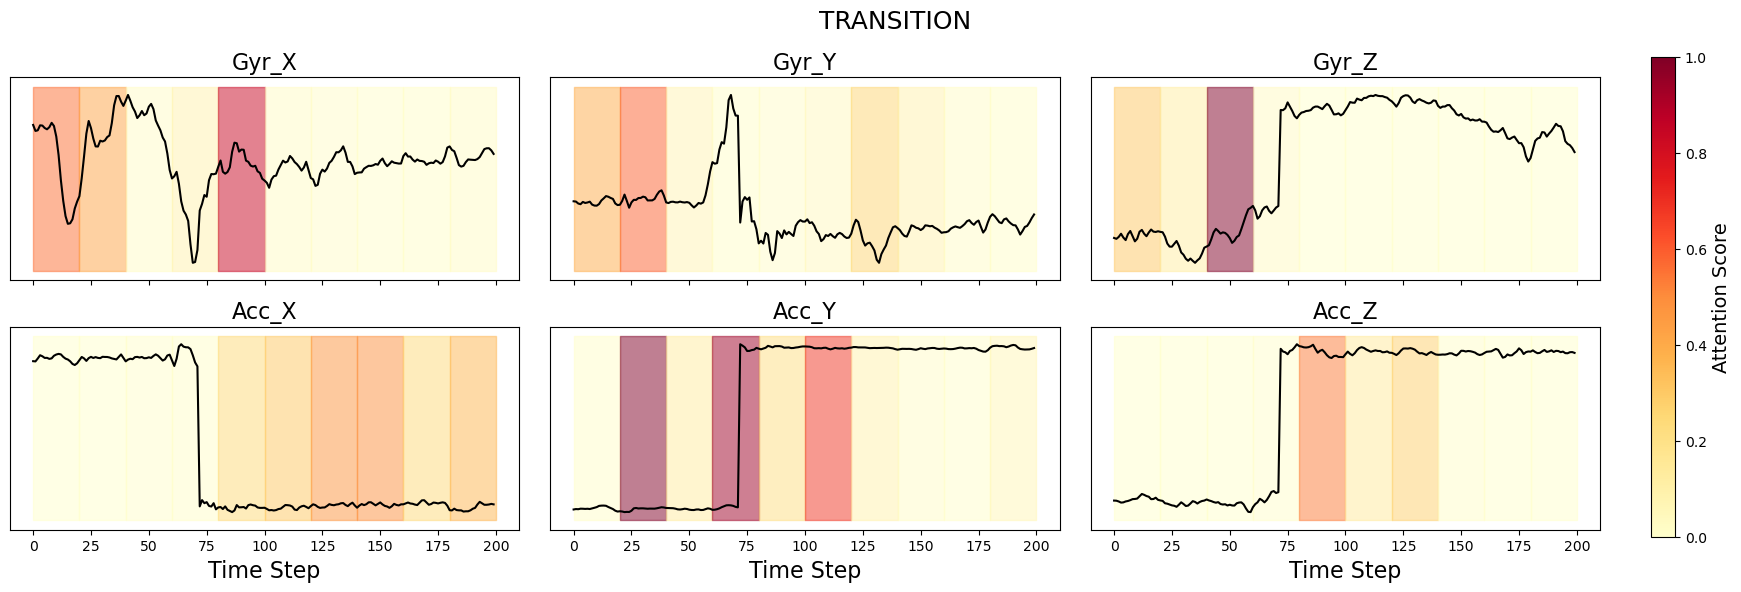

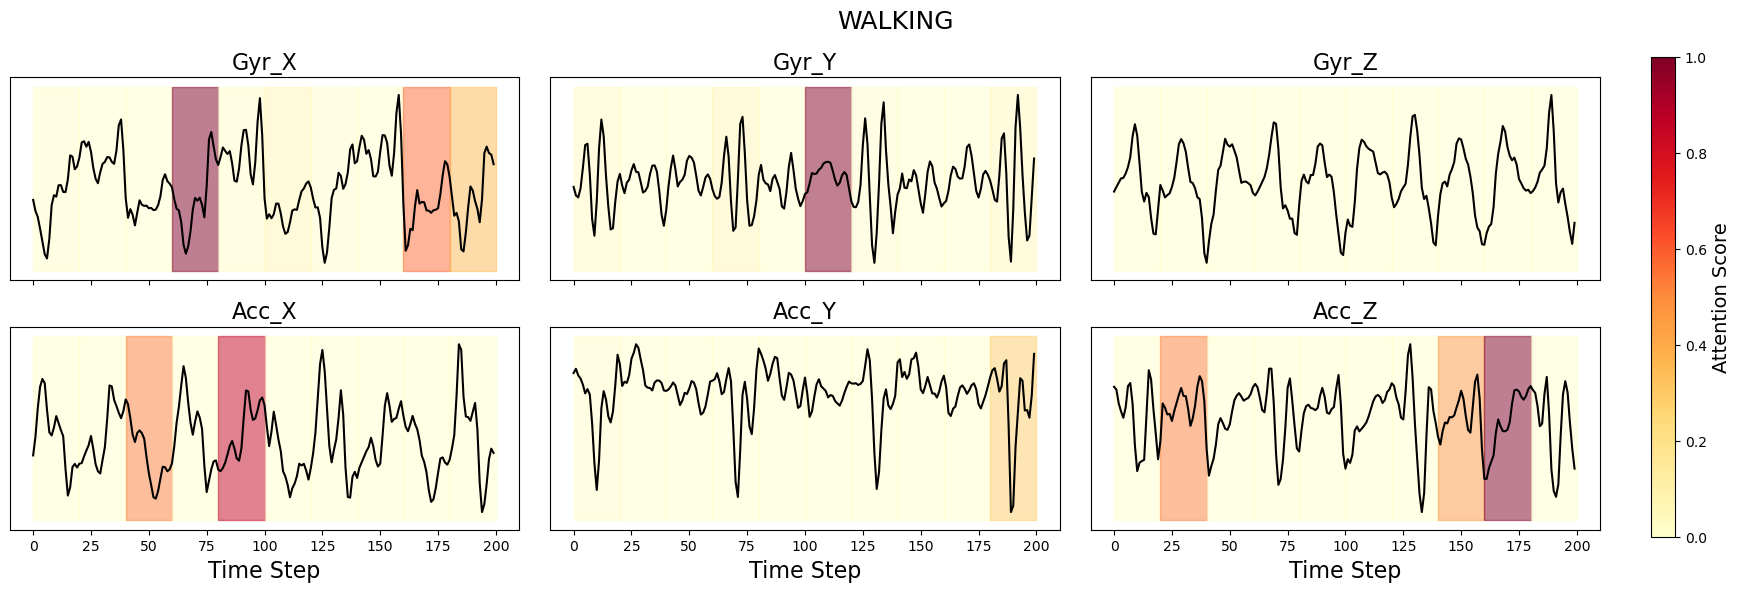

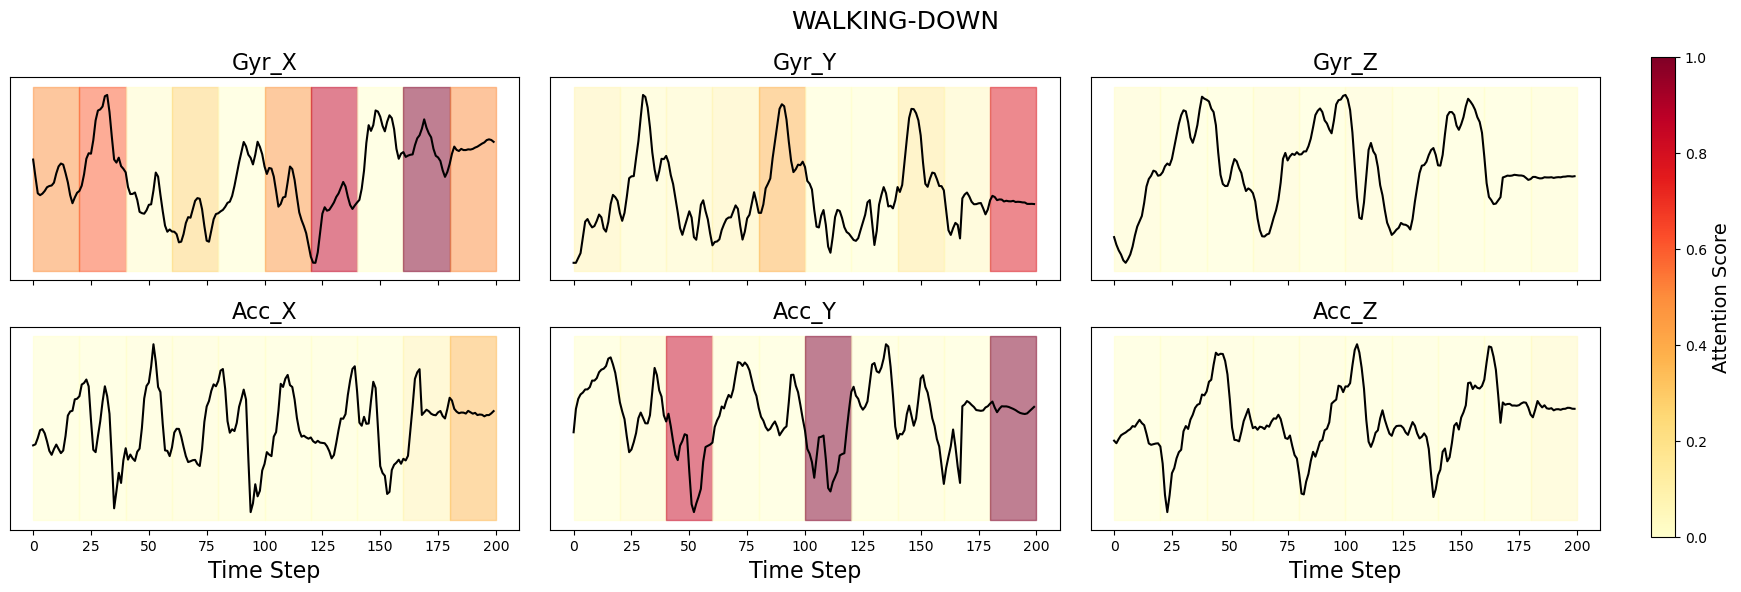

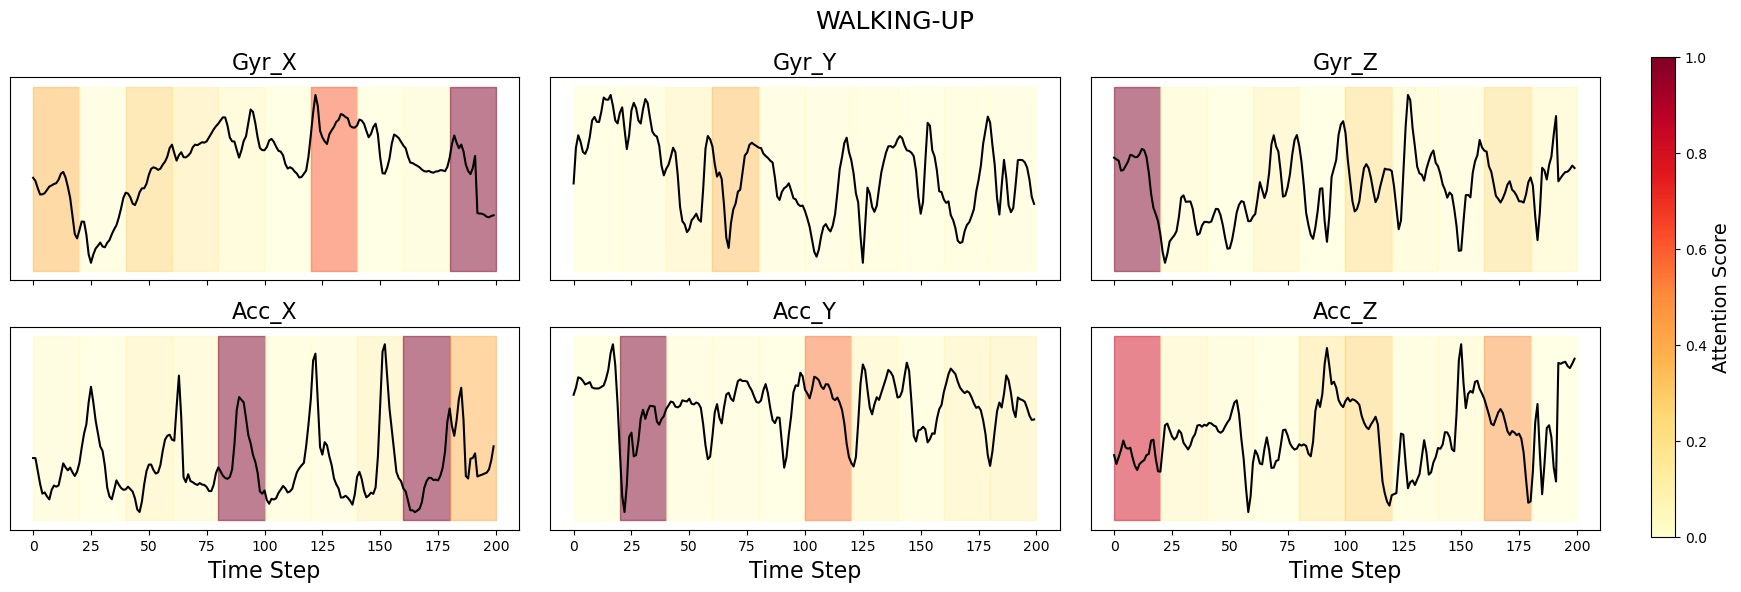

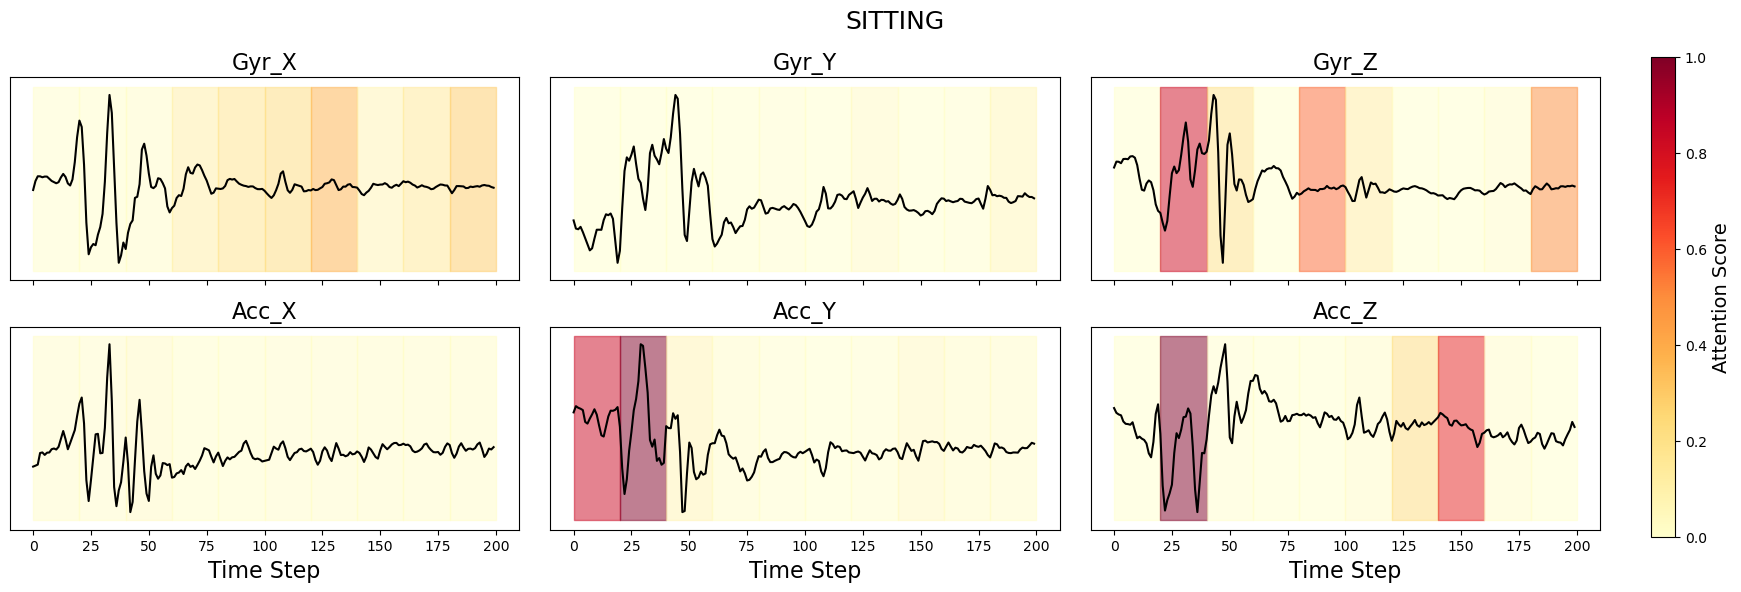

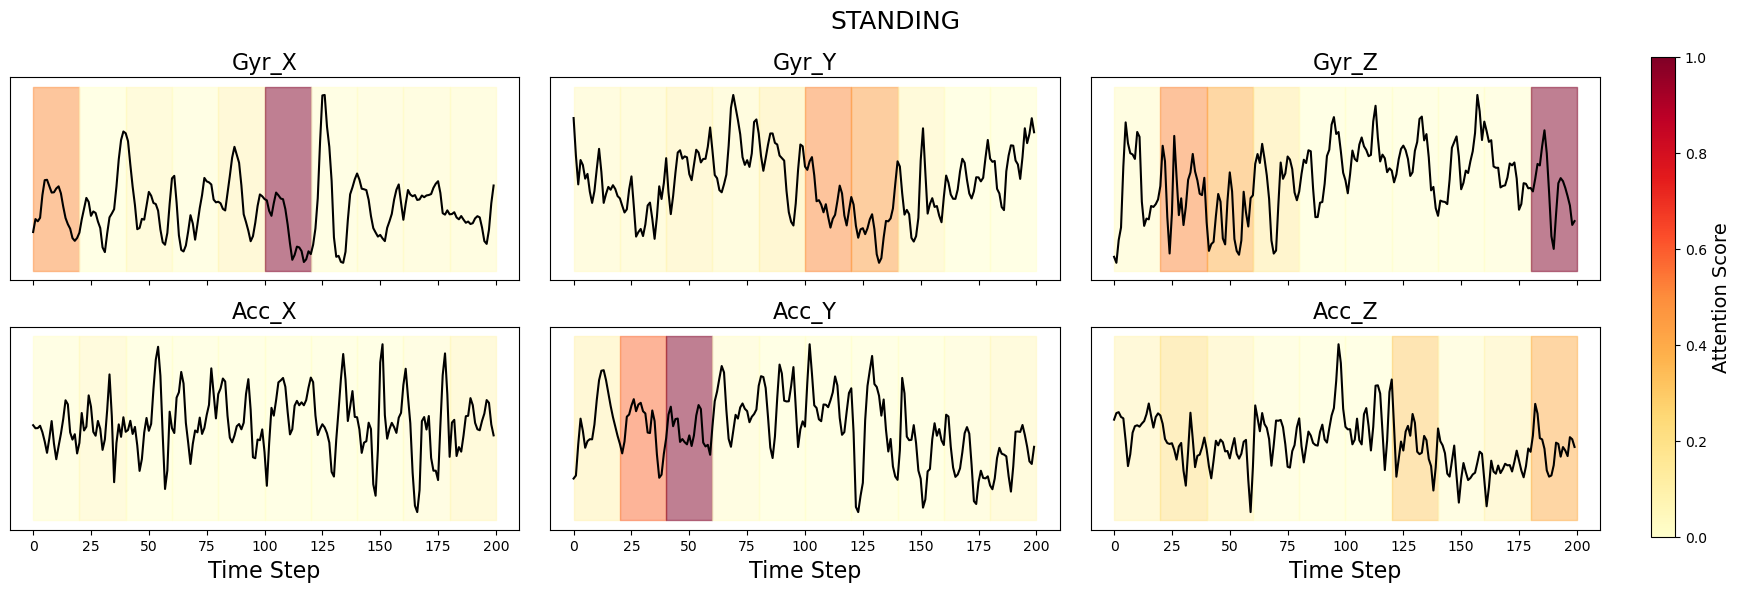

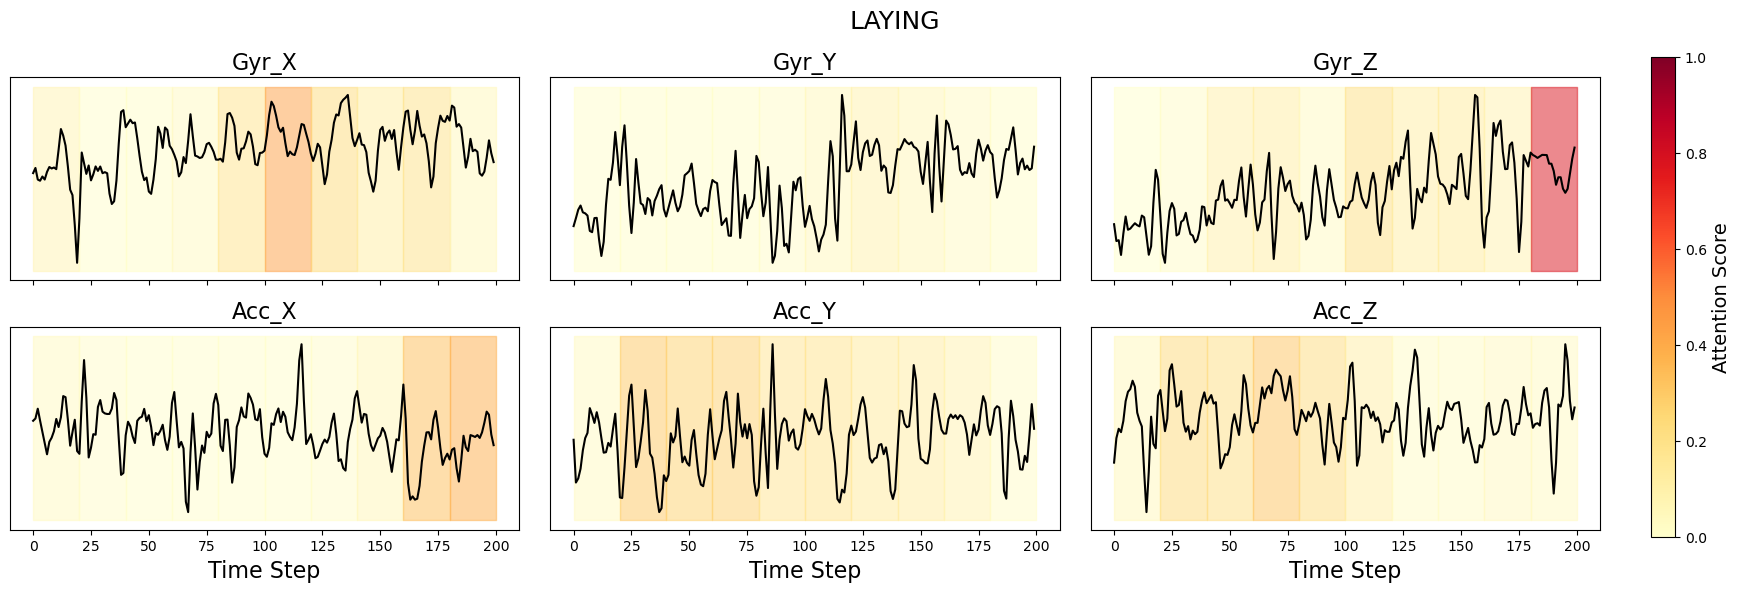

In [15]:
process_all_samples(model, test_seq, test_seq_y, sample_indices, mask_ratio=0)

Start plotting for sample index 6 of activity 'TRANSITION'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0], device='cuda:0')
The prediction is correct!
Attention Map for layer 1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])


/tmp/ipykernel_123252/3693679291.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right space to accommodate colorbar


-----------------------------------------------------------------
Start plotting for sample index 9 of activity 'WALKING'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([1.])
Prediction: tensor([1], device='cuda:0')
The prediction is correct!
Attention Map for layer 1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 19 of activity 'WALKING-DOWN'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([2.])
Prediction: tensor([2], device='cuda:0')
The prediction is correct!
Attention Map for layer 1
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 18 of activity 'WALKING-UP'
Samp

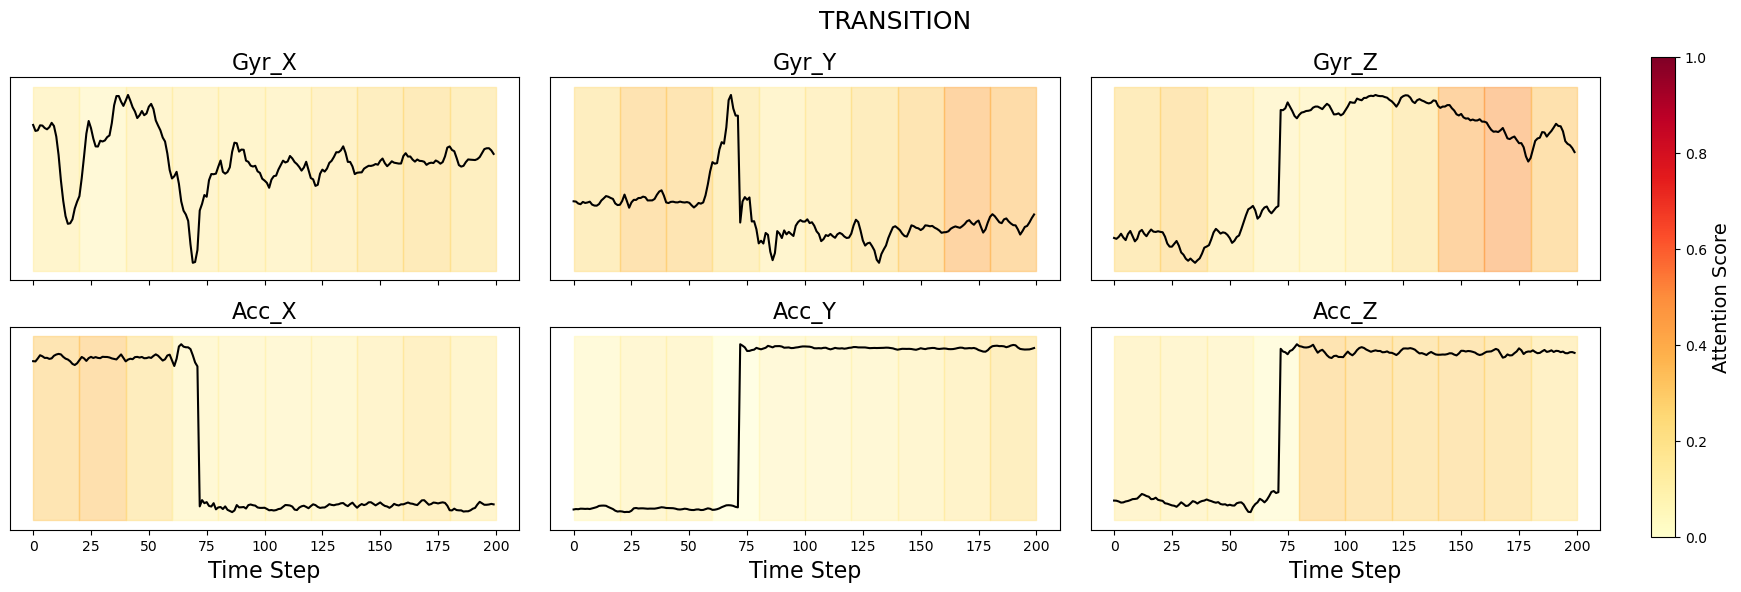

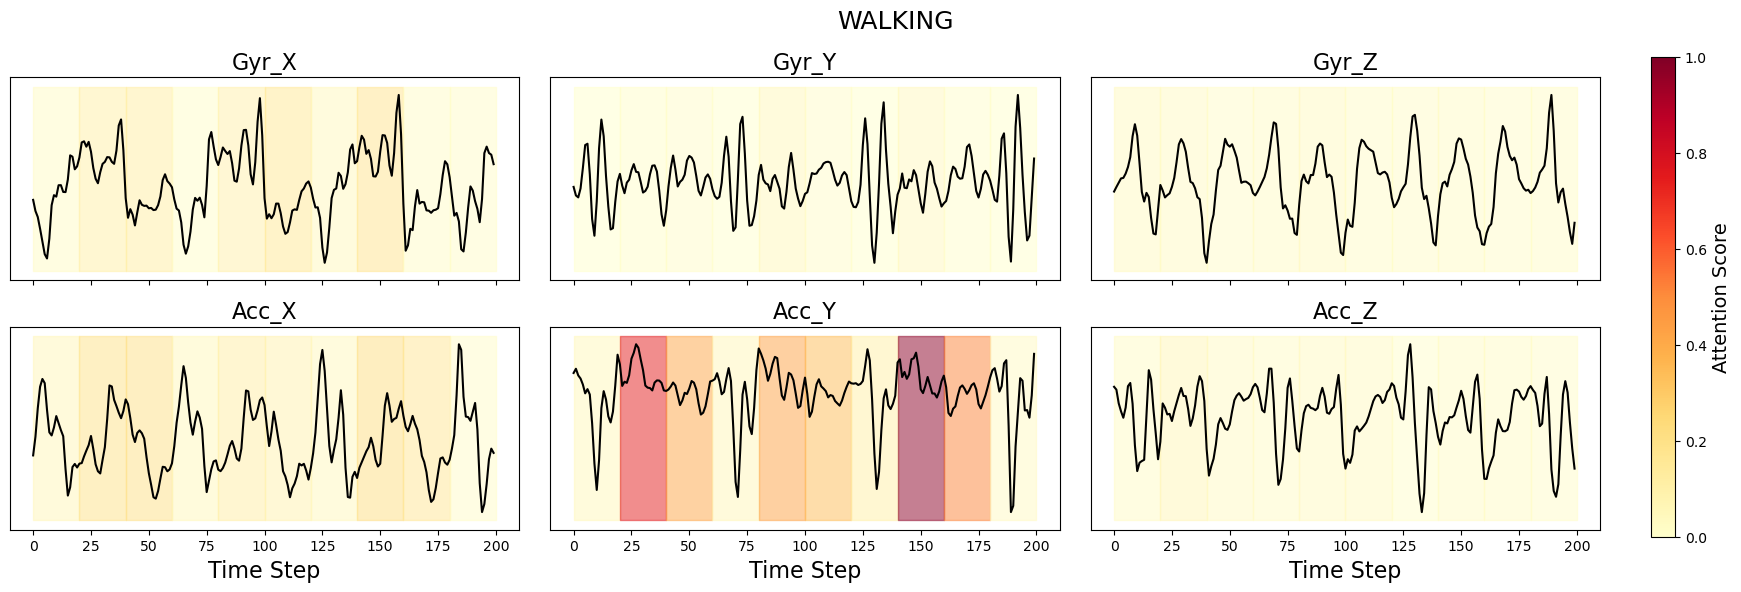

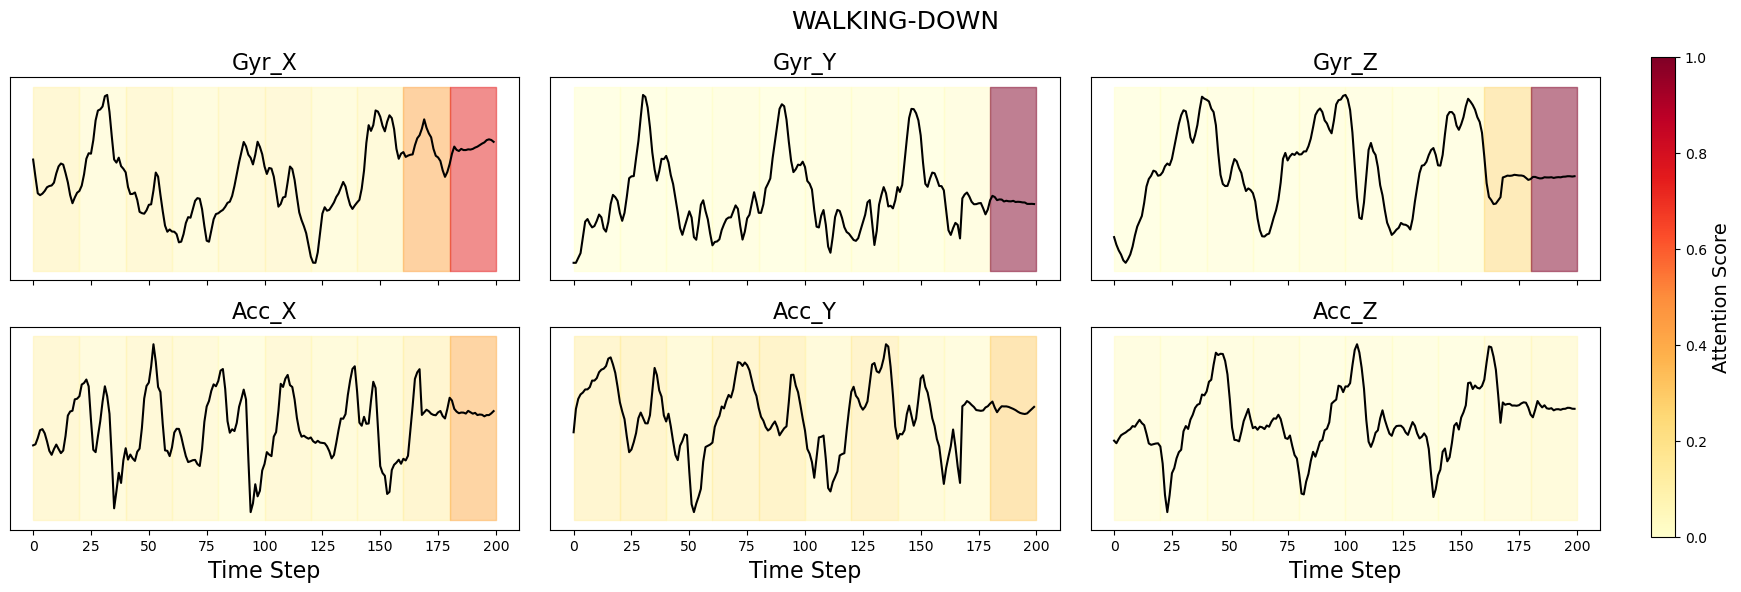

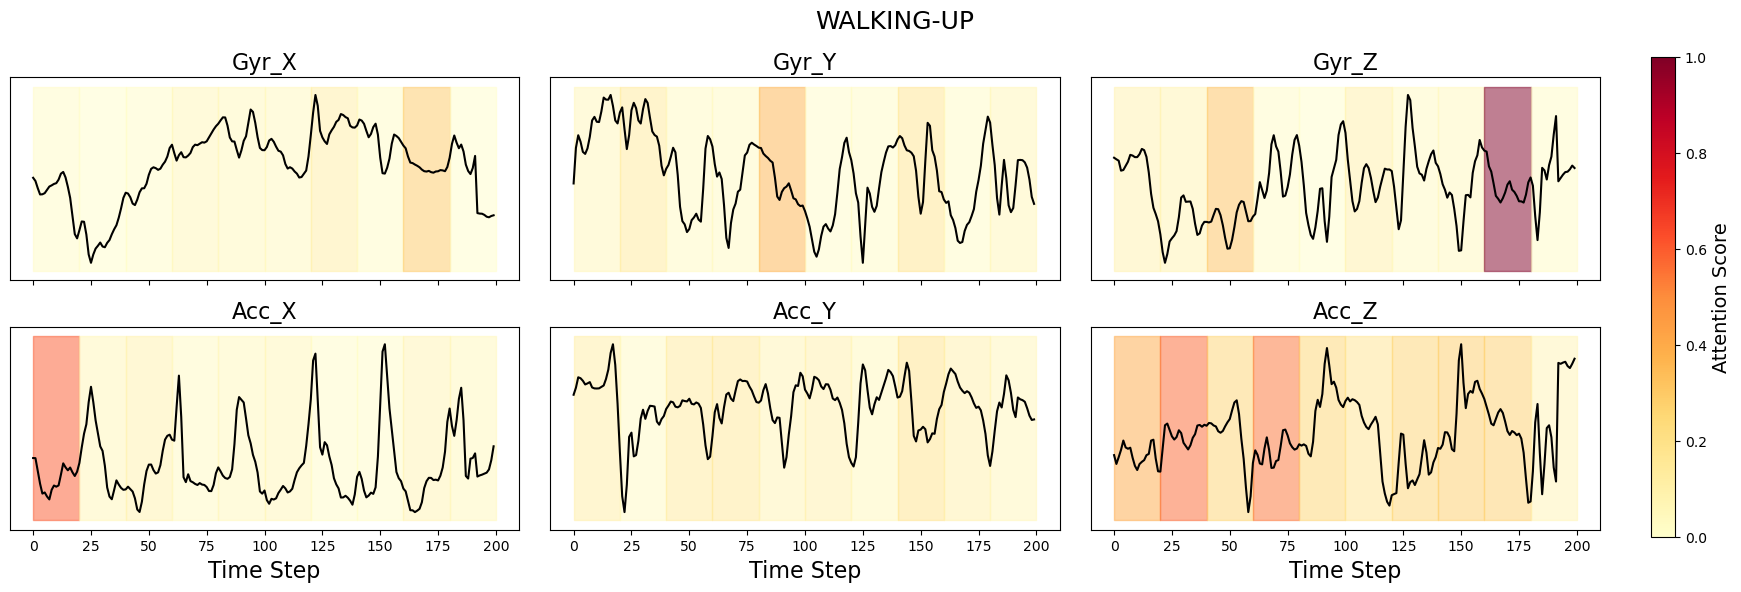

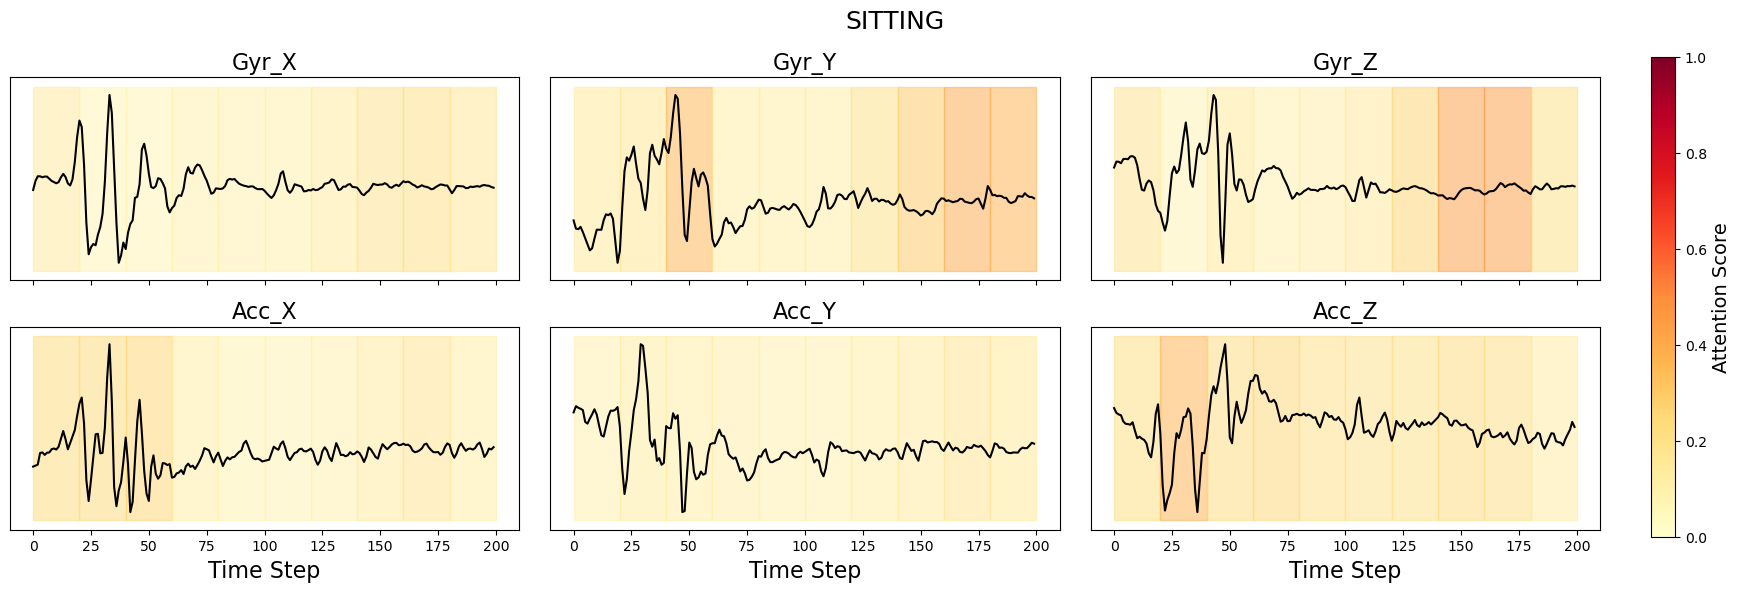

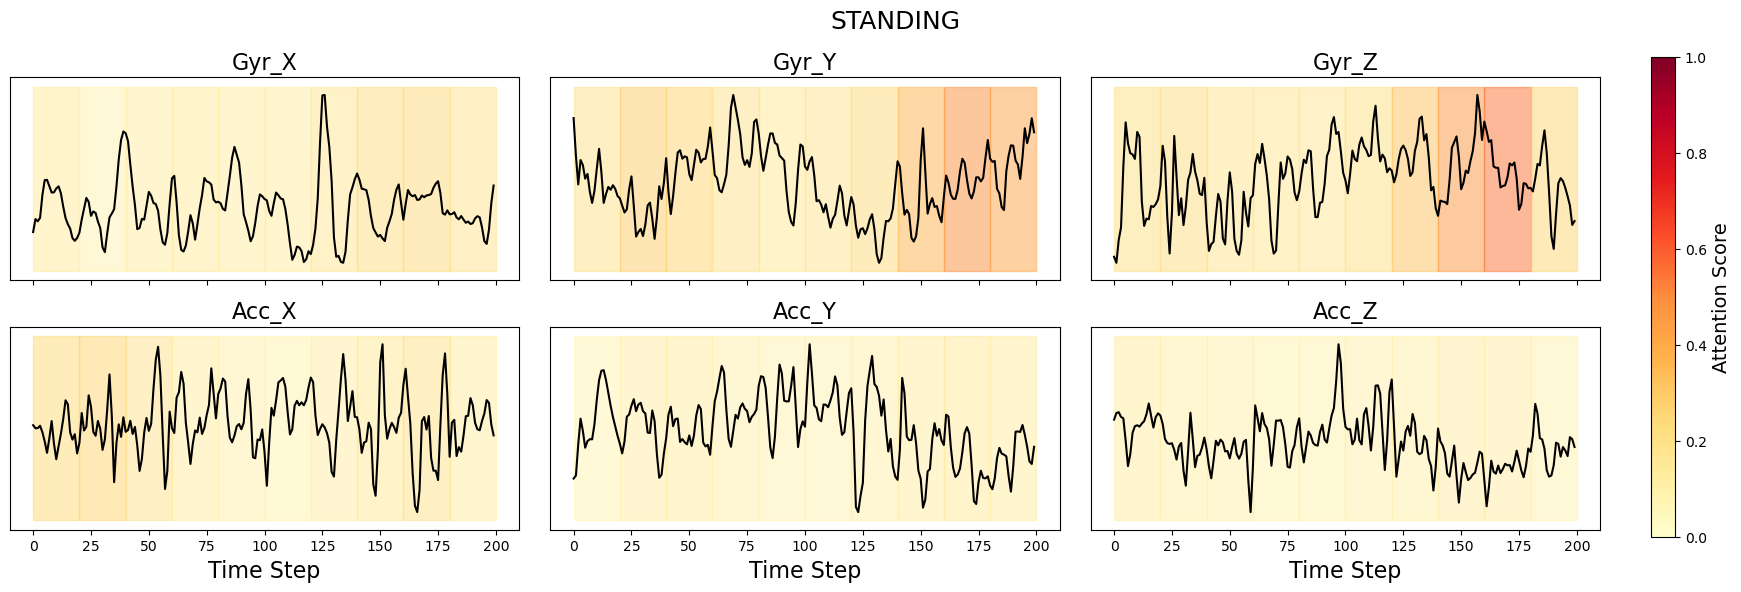

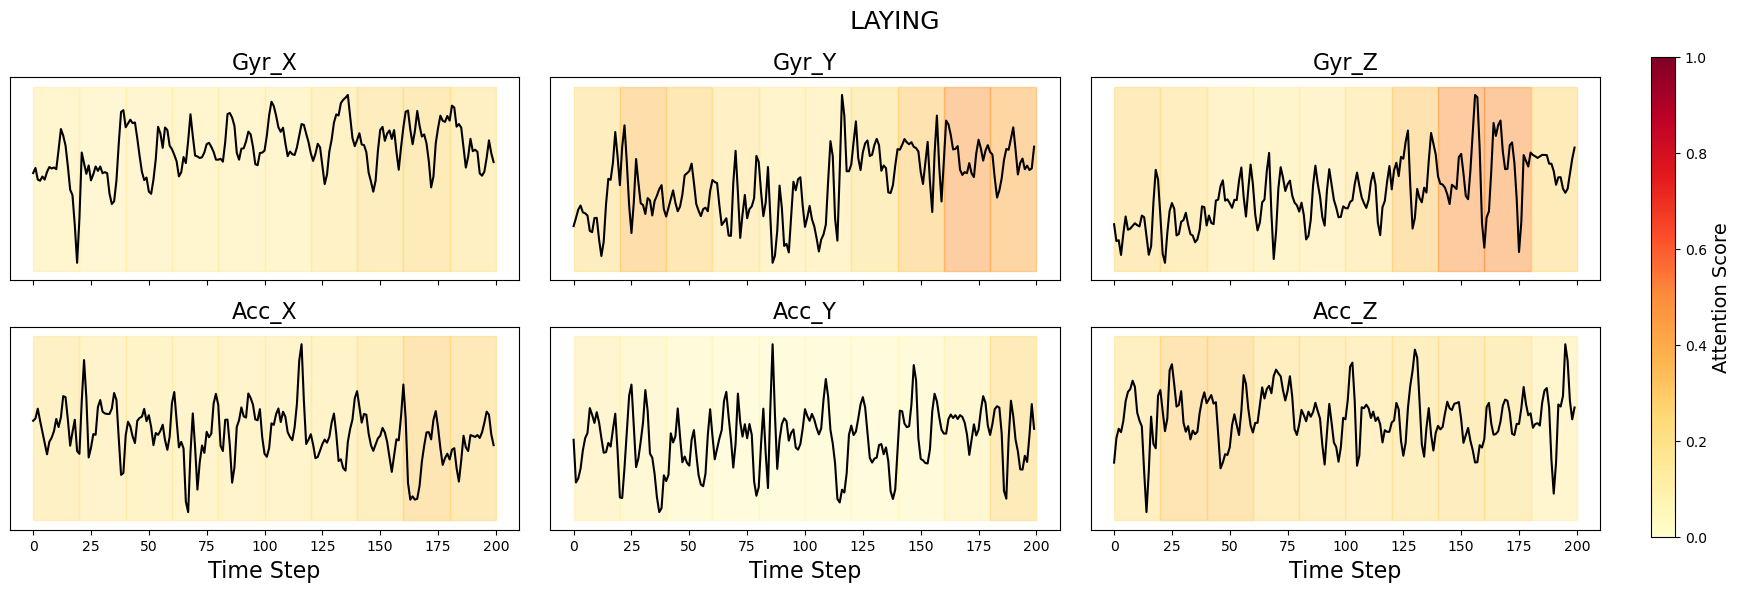

In [16]:
layer=1
model.blocks[layer].attn.forward = my_forward_wrapper(model.blocks[layer].attn)
process_all_samples(model, test_seq, test_seq_y, sample_indices,layer = layer,mask_ratio=0)

Start plotting for sample index 6 of activity 'TRANSITION'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0], device='cuda:0')
The prediction is correct!
Attention Map for layer 10
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])


/tmp/ipykernel_123252/3693679291.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right space to accommodate colorbar


-----------------------------------------------------------------
Start plotting for sample index 9 of activity 'WALKING'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([1.])
Prediction: tensor([1], device='cuda:0')
The prediction is correct!
Attention Map for layer 10
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 19 of activity 'WALKING-DOWN'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([2.])
Prediction: tensor([2], device='cuda:0')
The prediction is correct!
Attention Map for layer 10
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 18 of activity 'WALKING-UP'
Sa

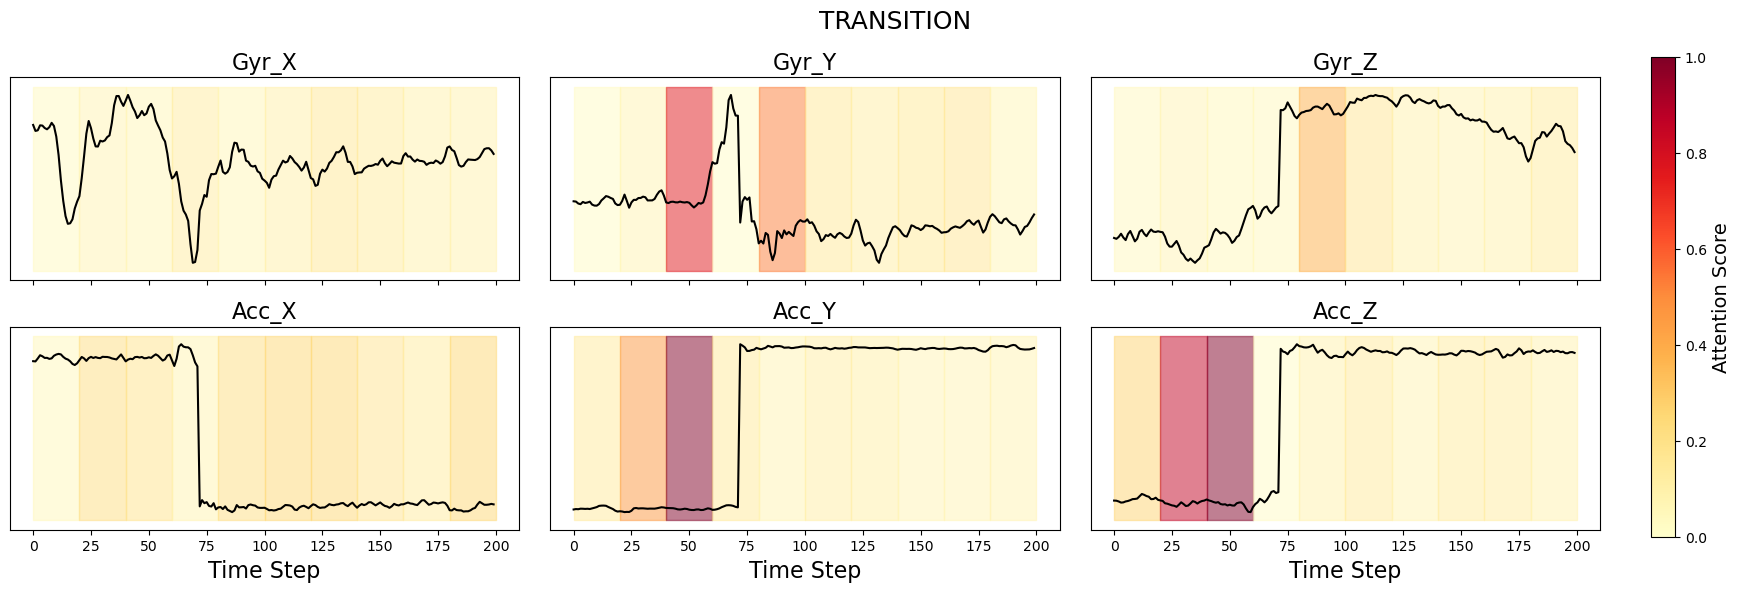

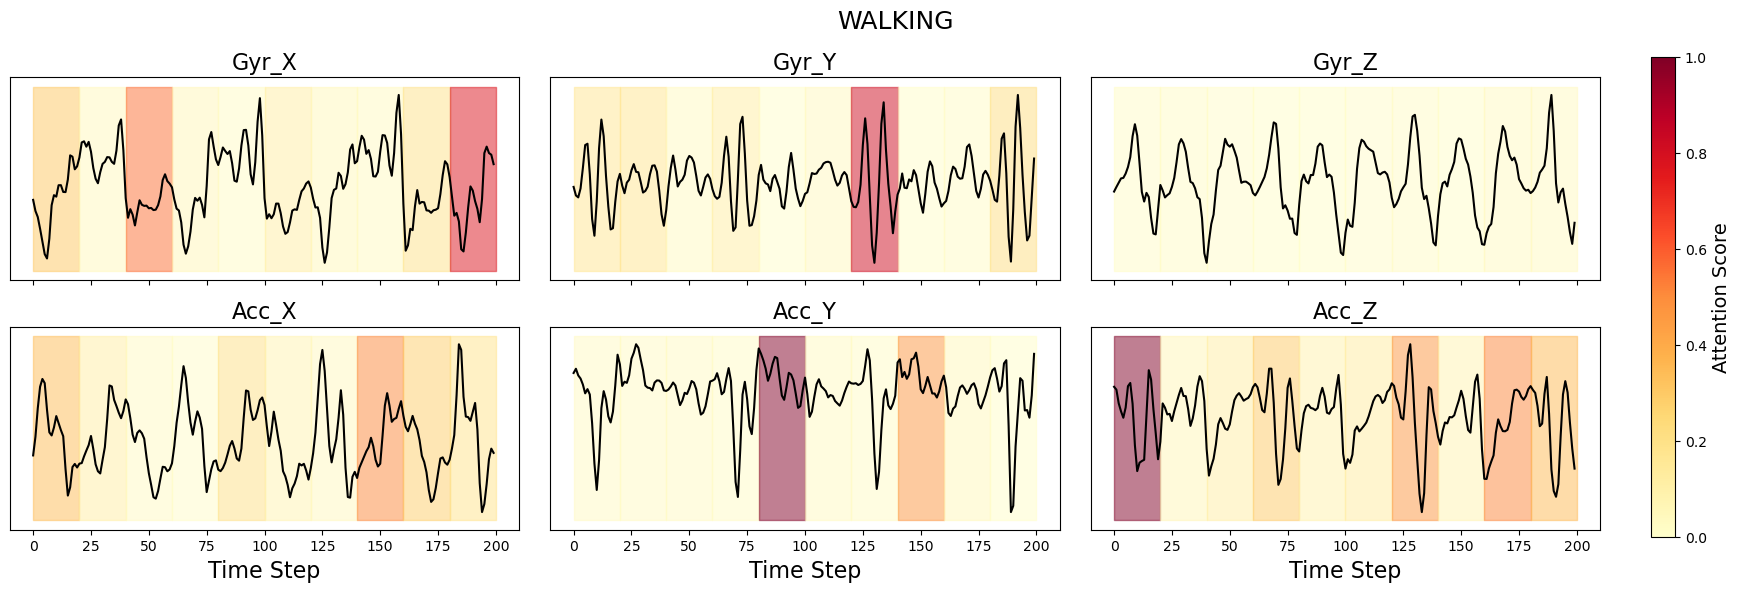

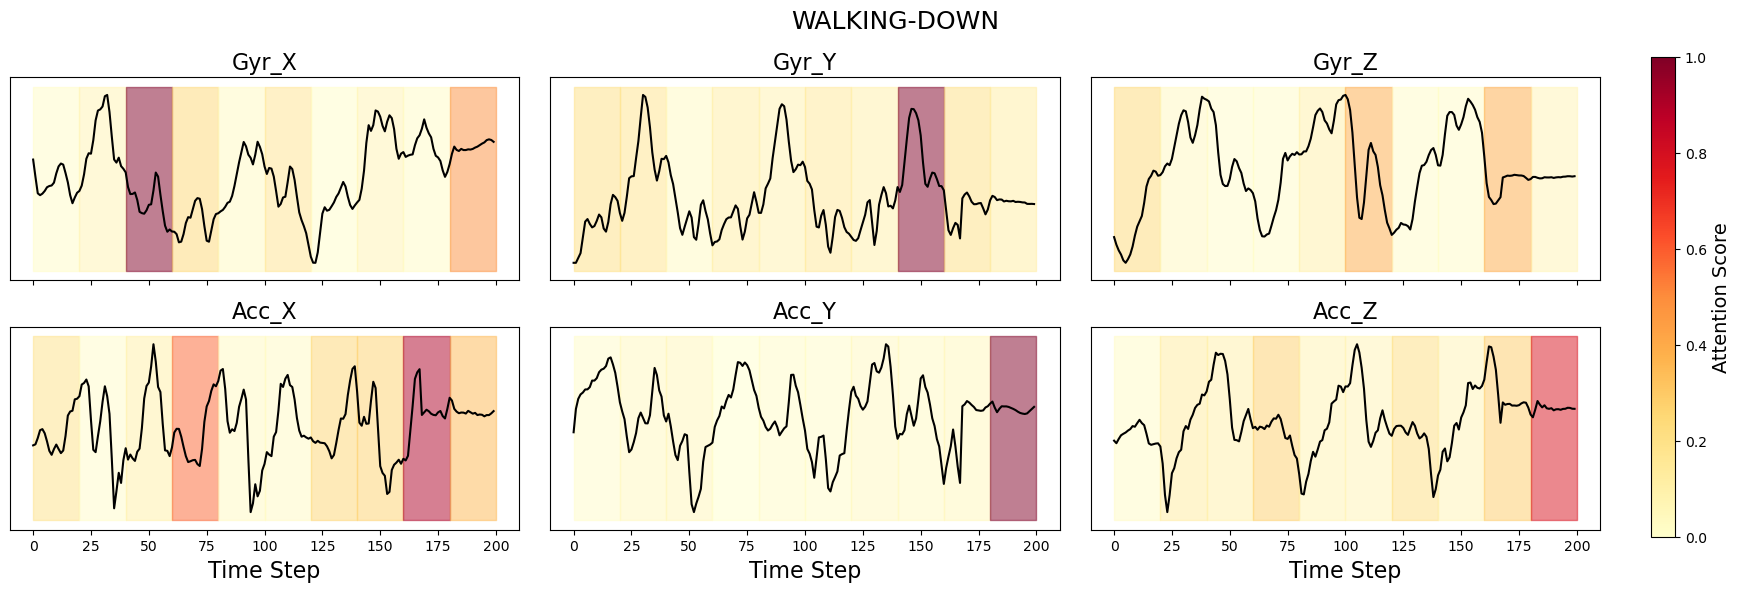

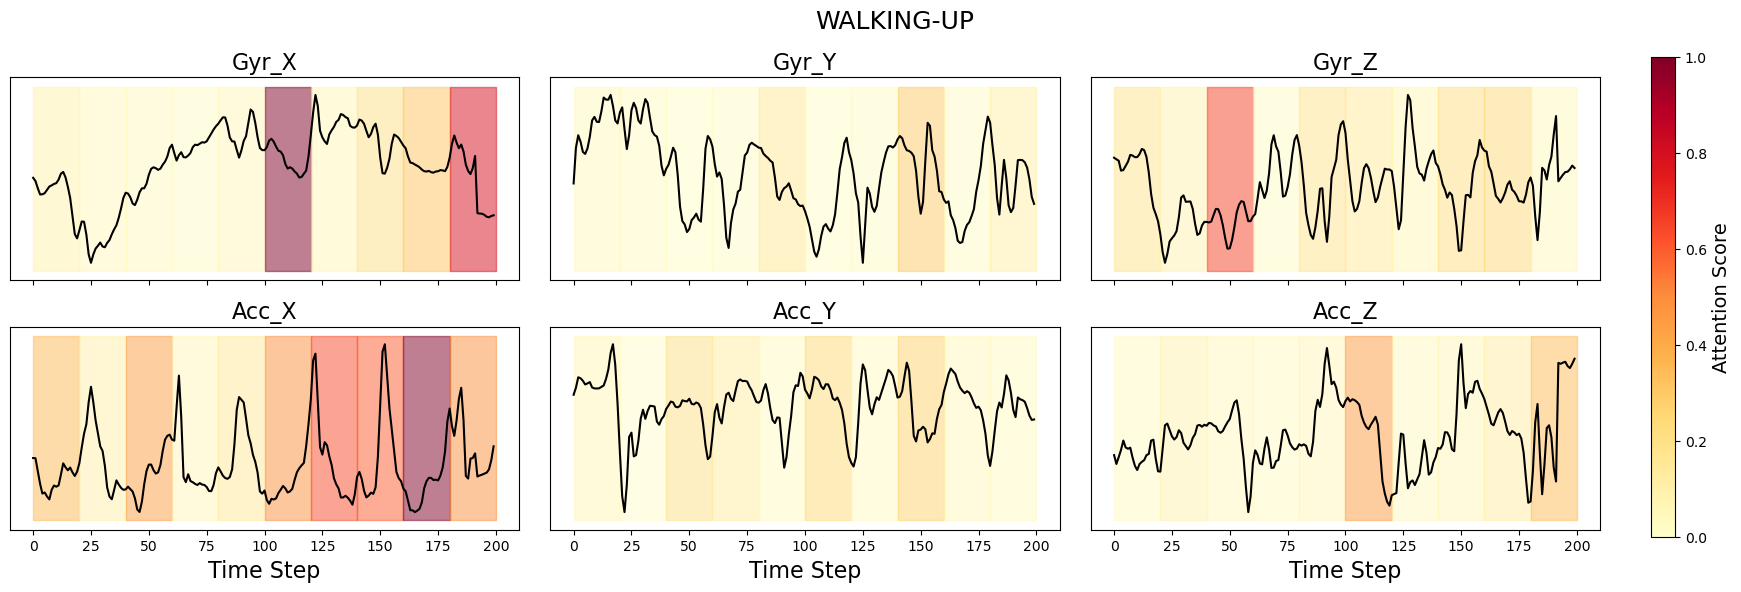

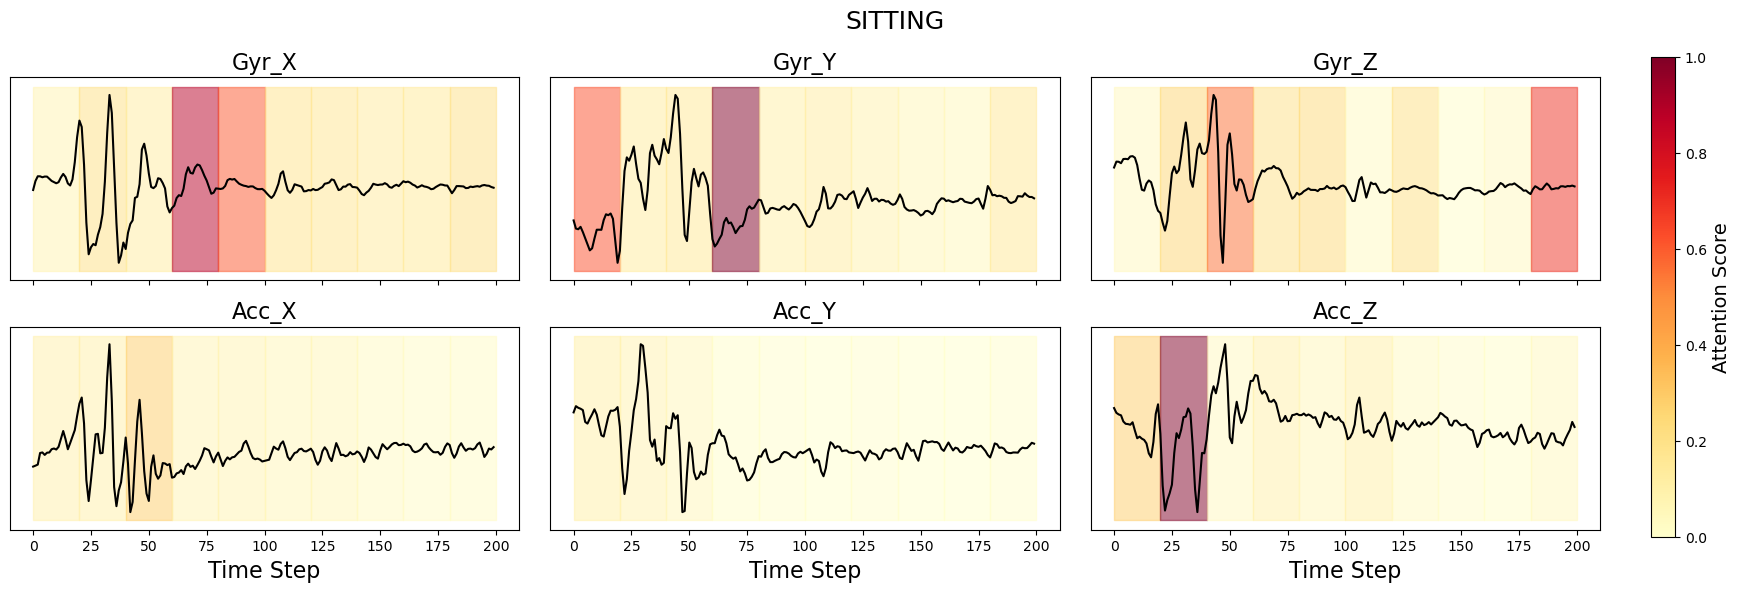

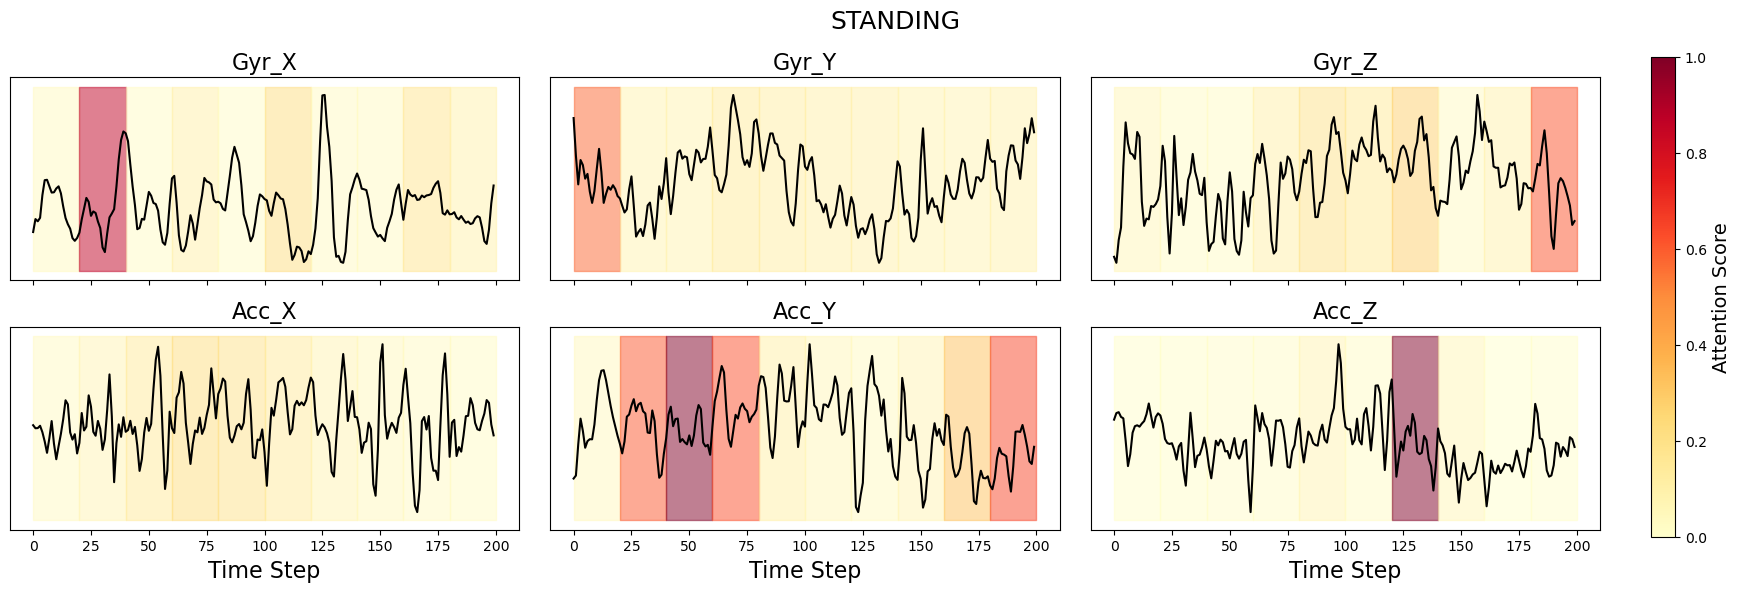

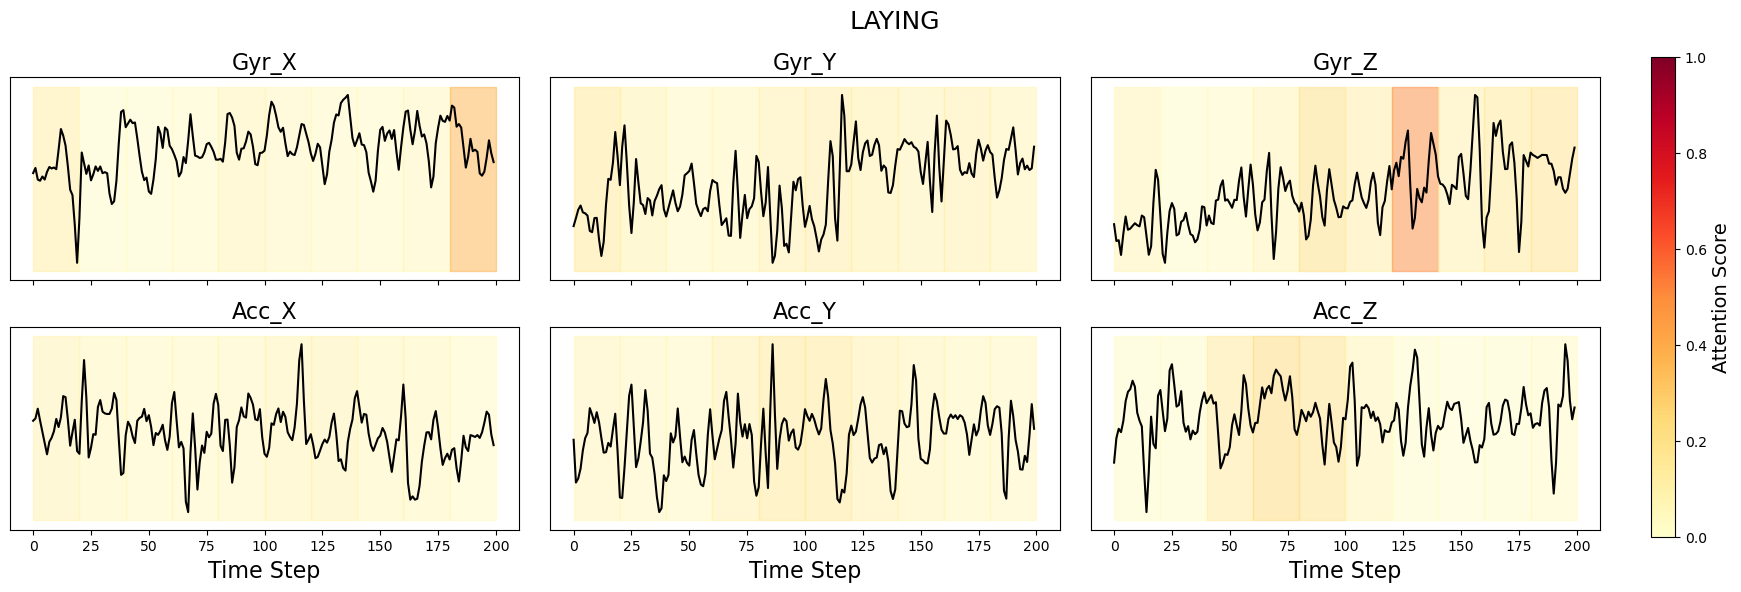

In [18]:
layer=10
model.blocks[layer].attn.forward = my_forward_wrapper(model.blocks[layer].attn)
process_all_samples(model, test_seq, test_seq_y, sample_indices,layer = layer,mask_ratio=0)

# Find all transition indicies

In [ ]:
import numpy as np

# Define activity labels
activity_labels = {
    0: "TRANSITION",
    1: "WALKING",
    2: "WALKING-DOWN",
    3: "WALKING-UP",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# Example: Assume you want to find all samples of the "TRANSITION" activity
activity = "TRANSITION"
activity_id = list(activity_labels.keys())[list(activity_labels.values()).index(activity)]

# Find all sample indices for the specified activity
sample_indices_array = np.where(test_seq_y == activity_id)[0]

# Initialize the sample_indices dictionary
sample_indices = {}

# Populate the dictionary with indices
for i in sample_indices_array:
    sample_indices[f"{activity}_{i}"] = i

# Print the dictionary
if sample_indices:
    print(f"Sample indices for {activity}: {sample_indices}")
else:
    print(f"No samples found for {activity}.")


Sample indices for TRANSITION: {'TRANSITION_6': 6, 'TRANSITION_12': 12, 'TRANSITION_34': 34, 'TRANSITION_43': 43, 'TRANSITION_49': 49, 'TRANSITION_75': 75, 'TRANSITION_80': 80, 'TRANSITION_133': 133, 'TRANSITION_152': 152, 'TRANSITION_205': 205, 'TRANSITION_222': 222, 'TRANSITION_241': 241, 'TRANSITION_294': 294, 'TRANSITION_323': 323, 'TRANSITION_335': 335, 'TRANSITION_340': 340, 'TRANSITION_342': 342, 'TRANSITION_435': 435, 'TRANSITION_438': 438, 'TRANSITION_466': 466, 'TRANSITION_467': 467, 'TRANSITION_528': 528, 'TRANSITION_535': 535, 'TRANSITION_542': 542, 'TRANSITION_607': 607, 'TRANSITION_623': 623, 'TRANSITION_671': 671, 'TRANSITION_684': 684, 'TRANSITION_717': 717, 'TRANSITION_719': 719, 'TRANSITION_740': 740, 'TRANSITION_777': 777}


In [ ]:
process_all_samples(model, test_seq, test_seq_y, sample_indices, mask_ratio=0,save_html=True)

Start plotting for sample index 6 of activity 'TRANSITION_6'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0], device='cuda:0')
The prediction is correct!
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])


/tmp/ipykernel_1758/3693679291.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right space to accommodate colorbar


-----------------------------------------------------------------
Start plotting for sample index 12 of activity 'TRANSITION_12'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([3], device='cuda:0')
The prediction is incorrect.
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 34 of activity 'TRANSITION_34'
Sample shape: torch.Size([1, 1, 6, 200])
Ground truth: tensor([0.])
Prediction: tensor([0], device='cuda:0')
The prediction is correct!
Attention map shape: torch.Size([61, 61])
CLS token attention map to patches shape: torch.Size([1, 61])
attention map to plot:  torch.Size([6, 10])
-----------------------------------------------------------------
Start plotting for sample index 43 of activity 'TRANSITION_43'
Sample shape: torch.Size([1, 1, 6, 200])
Gr

## Training Loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load the CSV file
file_path = 'training_loss.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Step 2: Set the darkgrid style
sns.set(style="darkgrid")

# Step 3: Convert 'Wall time' to hours
data['Wall time'] = (data['Wall time'] - data['Wall time'].min()) / 3600  # Convert wall time to hours

# Step 4: Create the plot with dual x-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Use ICLR-like font settings
plt.rcParams['font.family'] = 'serif'  # Set font to serif
plt.rcParams['font.serif'] = ['Times New Roman']  # Use Times New Roman
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Primary x-axis: Steps
ax1.plot(data['Step'], data['Value'], label='Loss', color='cornflowerblue')
ax1.set_xlabel('Steps', fontsize=14, labelpad=15, fontweight='bold')  # Bold x-axis label
ax1.set_ylabel('Loss', fontsize=14, labelpad=15, fontweight='bold')   # Bold y-axis label
ax1.set_title('Training Loss over Time', fontsize=16, pad=30)  # Add extra space above the title
ax1.grid(True)

# Adjust font sizes for the x and y ticks with additional padding
ax1.tick_params(axis='both', labelsize=12, pad=10)  # Increase pad for ticks

# Secondary x-axis: Time in hours (at the top)
ax2 = ax1.twiny()  # Create a secondary x-axis

# Get the tick positions from the primary axis (Steps)
ticks = ax1.get_xticks()

# Get corresponding 'Wall time' values for the tick positions
# Interpolating time labels based on the current step ticks
time_labels = np.interp(ticks, data['Step'], data['Wall time'])

# Set ticks and labels on the secondary x-axis
ax2.set_xticks(ticks)  # Ensure both axes have the same ticks
ax2.set_xticklabels([f'{t:.2f}' for t in time_labels], fontsize=12)
ax2.set_xlabel('Time (hours)', fontsize=14, labelpad=15, fontweight='bold')  # Bold secondary x-axis label

# Set the x-limits of the secondary axis to match the primary
ax2.set_xlim(ax1.get_xlim())

# Hide the secondary axis ticks if primary axis ticks are not present
if len(ticks) == 0:
    ax2.set_xticks([])

# Adjust the ticks and ensure the layout adjusts well to avoid overlap
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'training_loss.csv'

## Theory Demo

In [ ]:
from models_mae import MaskedAutoencoderViT
import torch
cross_6_200_model = MaskedAutoencoderViT(
    img_size=[6, int(200)],
    patch_size=[1, int(20)],
    in_chans=1,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4,
)


/Users/leo/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/leo/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/leo/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A54E39C4-6B62-3303-9BE6-7DB88EB078BF> /Users/leo/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


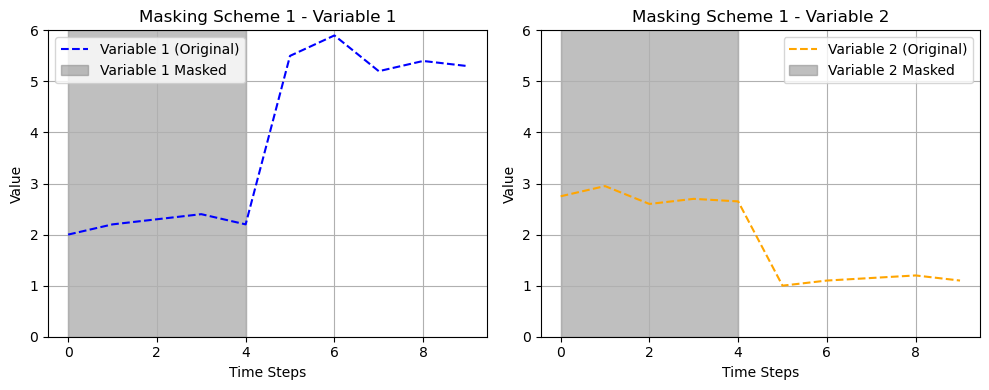

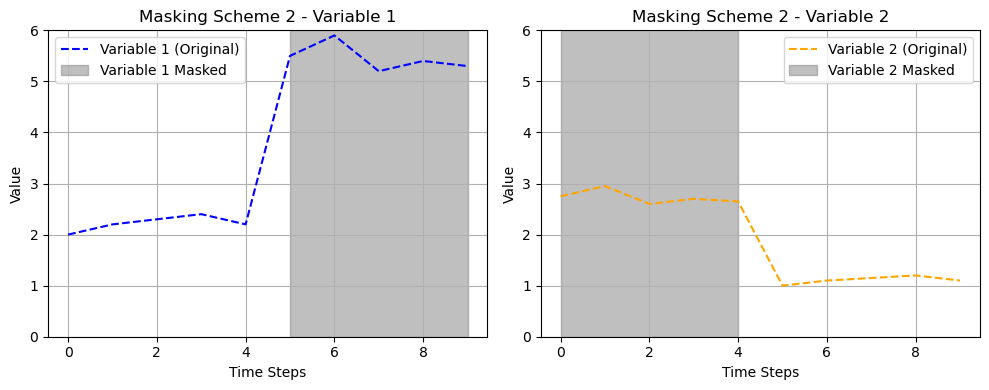

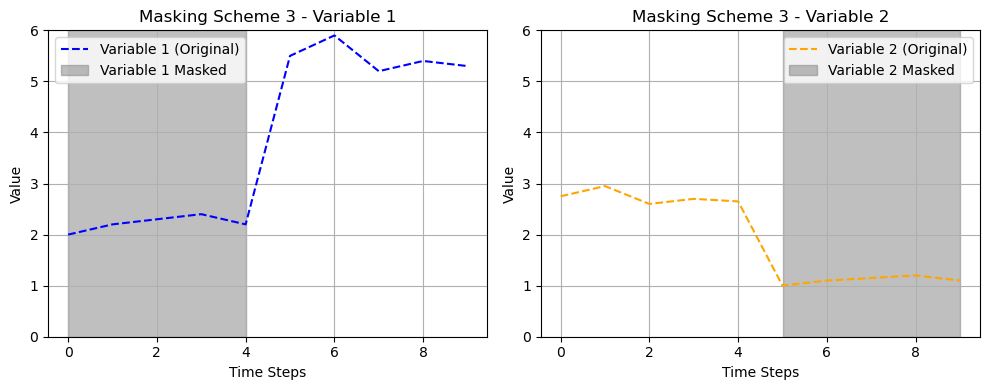

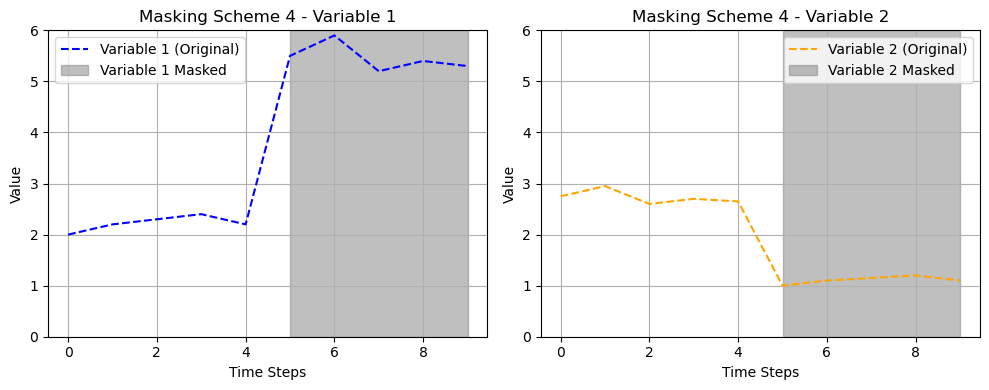

In [ ]:
# Re-importing necessary libraries after environment reset
import matplotlib.pyplot as plt

# Define the multivariate time series (2 variables, 10 time steps)
series = [
    [2, 2.2, 2.3, 2.4, 2.2, 5.5, 5.9, 5.2, 5.4, 5.3],  # Variable 1
    [x / 2 for x in [5.5, 5.9, 5.2, 5.4, 5.3, 2, 2.2, 2.3, 2.4, 2.2, ]]  # Variable 2
]

# Masking schemes
mask_schemes = [
    (range(0, 5), range(0, 5)),  # Mask first 5 numbers of both variables
    (range(5, 10), range(0, 5)), # Mask last 5 of var 1, first 5 of var 2
    (range(0, 5), range(5, 10)), # Mask first 5 of var 1, last 5 of var 2
    (range(5, 10), range(5, 10)) # Mask last 5 numbers of both variables
]

# Generate separate plots for each variable to show masking schemes
for i, (mask_var1, mask_var2) in enumerate(mask_schemes):
    plt.figure(figsize=(10, 4))
    
    # Plot for Variable 1
    plt.subplot(1, 2, 1)
    plt.plot(series[0], label="Variable 1 (Original)", linestyle="--", color="blue")
    plt.fill_between(range(10), 0, 6, where=[j in mask_var1 for j in range(10)],
                     color="gray", alpha=0.5, label="Variable 1 Masked")
    plt.title(f"Masking Scheme {i+1} - Variable 1")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.ylim(0, 6)
    plt.grid(True)
    plt.legend()

    # Plot for Variable 2
    plt.subplot(1, 2, 2)
    plt.plot(series[1], label="Variable 2 (Original)", linestyle="--", color="orange")
    plt.fill_between(range(10), 0, 6, where=[j in mask_var2 for j in range(10)],
                     color="gray", alpha=0.5, label="Variable 2 Masked")
    plt.title(f"Masking Scheme {i+1} - Variable 2")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.ylim(0, 6)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


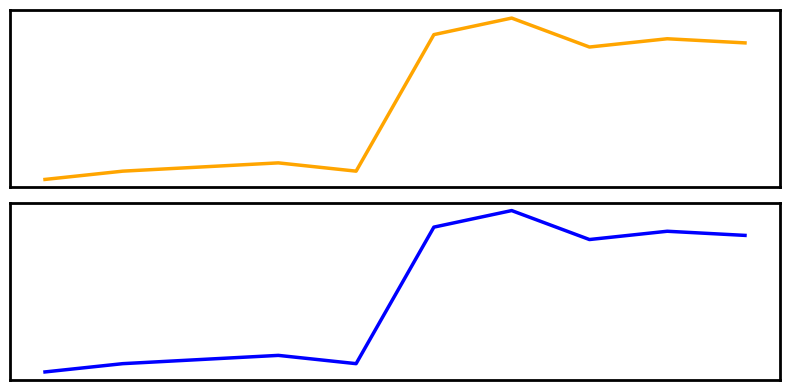

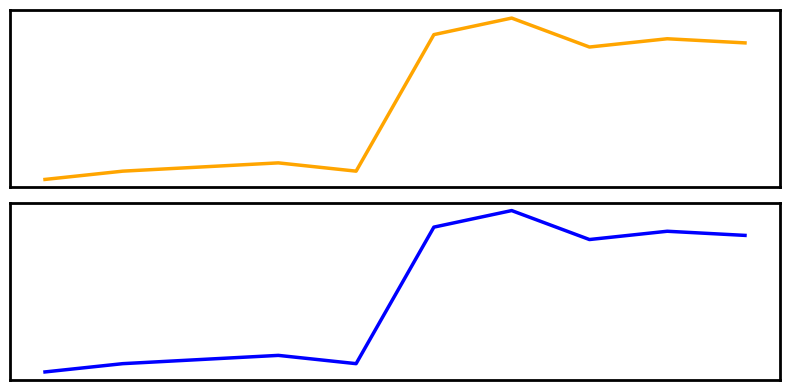

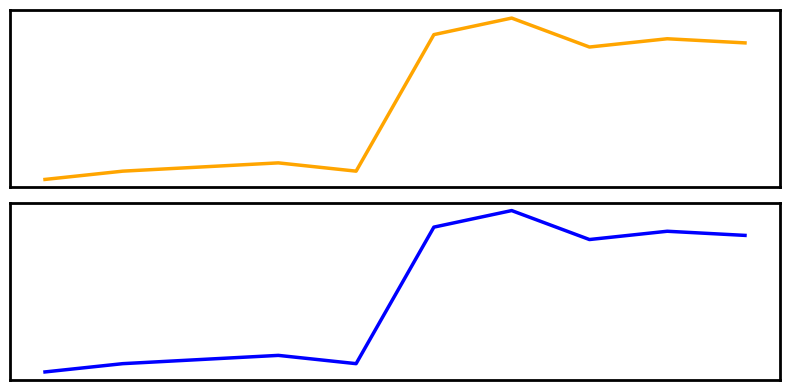

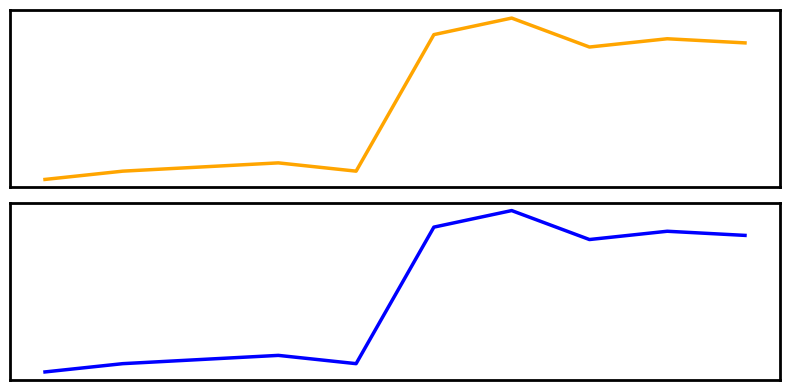

In [ ]:
import matplotlib.pyplot as plt

# Define the multivariate time series (2 variables, 10 time steps)
series = [
    [2, 2.2, 2.3, 2.4, 2.2, 5.5, 5.9, 5.2, 5.4, 5.3],  # Variable 1
    [x / 2 for x in [2, 2.2, 2.3, 2.4, 2.2, 5.5, 5.9, 5.2, 5.4, 5.3]]  # Variable 2
]

# Masking schemes
mask_schemes = [
    (range(0, 5), range(0, 5)),  # Mask first 5 numbers of both variables
    (range(4, 10), range(0, 5)), # Mask last 5 of var 1, first 5 of var 2
    (range(0, 5), range(4, 10)), # Mask first 5 of var 1, last 5 of var 2
    (range(4, 10), range(4, 10)) # Mask last 5 numbers of both variables
]

# Generate separate plots for each masking scheme
# for i, (mask_var1, mask_var2) in enumerate(mask_schemes):
#     plt.figure(figsize=(8, 4))
    
#     # Plot for Variable 1 (top)
#     plt.subplot(2, 1, 1)
#     plt.plot(series[0], linestyle="-", color="blue")
#     # plt.fill_between(range(10), 0, 6, where=[j in mask_var1 for j in range(10)],
#     #                  color="gray", alpha=0.5)
#     plt.gca().set_xticks([])  # Remove x-axis ticks
#     plt.gca().set_yticks([])  # Remove y-axis ticks
#     plt.gca().spines["top"].set_visible(True)
#     plt.gca().spines["right"].set_visible(True)
#     plt.gca().spines["left"].set_visible(True)
#     plt.gca().spines["bottom"].set_visible(True)

#     # Plot for Variable 2 (bottom)
#     plt.subplot(2, 1, 2)
#     plt.plot(series[1], linestyle="-", color="black")
#     # plt.fill_between(range(10), 0, 6, where=[j in mask_var2 for j in range(10)],
#     #                  color="gray", alpha=0.5)
#     plt.gca().set_xticks([])  # Remove x-axis ticks
#     plt.gca().set_yticks([])  # Remove y-axis ticks
#     plt.gca().spines["top"].set_visible(True)
#     plt.gca().spines["right"].set_visible(True)
#     plt.gca().spines["left"].set_visible(True)
#     plt.gca().spines["bottom"].set_visible(True)

#     plt.tight_layout()
#     plt.show()
for i, (mask_var1, mask_var2) in enumerate(mask_schemes):
    plt.figure(figsize=(8, 4))
    
    # Plot for Variable 1 (top)
    plt.subplot(2, 1, 1)
    plt.plot(series[0], linestyle="-", color="orange",linewidth=2.5)
    plt.gca().set_xticks([])  # Remove x-axis ticks
    plt.gca().set_yticks([])  # Remove y-axis ticks
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set border thickness to 2

    # Plot for Variable 2 (bottom)
    plt.subplot(2, 1, 2)
    plt.plot(series[1], linestyle="-", color="Blue",linewidth=2.5)
    plt.gca().set_xticks([])  # Remove x-axis ticks
    plt.gca().set_yticks([])  # Remove y-axis ticks
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set border thickness to 2

    plt.tight_layout()
    plt.show()


In [1]:
import torch.profiler
import datetime
import os
from pathlib import Path
from main_pretrain import main, get_args_parser

# Parse args without CLI
parser = get_args_parser()
args = parser.parse_args([])

# Manually set arguments
args.batch_size = 128
args.masking_scheme = 'maxcut'
args.world_size = 1  # Single process, no DDP
args.epochs = 1  # Short run for profiling
args.warmup_epochs = 0
args.remark = 'maxcut_profile'
args.pre_mix_up = 0
# Generate log and output directories
initial_timestamp = datetime.datetime.now()
args.log_dir = f'./logdir/{args.remark}_{initial_timestamp.strftime("%Y-%m-%d_%H-%M")}'
args.output_dir = f'./output/{args.remark}_{initial_timestamp.strftime("%Y-%m-%d_%H-%M")}'
args.device = 'cuda'
Path(args.log_dir).mkdir(parents=True, exist_ok=True)
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

# Start profiler
with torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(args.log_dir),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    main(args, profiler=prof)


2025-04-03 22:58:30.897956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 22:58:31.606665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-03 22:58:31.606782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-03 22:58:31.606795: W tensorfl

Not using distributed mode
[22:58:32.921414] job dir: /home/jovyan/MAE_Accelerometer
[22:58:32.921486] Namespace(batch_size=128,
epochs=1,
accum_iter=1,
model='mae_vit_base_patch16',
input_size=200,
patch_size=20,
patch_num=10,
nvar=6,
mask_ratio=0.75,
masking_scheme='maxcut',
var_mask_ratio=0.0,
time_mask_ratio=0.75,
bert_pos_embed=0,
norm_pix_loss=False,
normalization=0,
loss_type='all',
weight_decay=0.05,
lr=None,
blr=0.001,
min_lr=1e-05,
warmup_epochs=0,
data_path='data/200',
alt=False,
output_dir='./output/maxcut_profile_2025-04-03_22-58',
log_dir='./logdir/maxcut_profile_2025-04-03_22-58',
device='cuda',
seed=0,
resume='',
learnable_mask=False,
mix_up=1,
pre_mix_up=0,
start_epoch=0,
num_workers=4,
pin_mem=True,
world_size=1,
local_rank=-1,
dist_on_itp=False,
dist_url='env://',
remark='maxcut_profile',
distributed=False)
[22:58:33.085440] training sample:  256
[22:58:33.085556] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7fe3dc39da20>
[22:58:36.003

STAGE:2025-04-03 22:58:47 4634:4634 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


[22:58:47.872095] Epoch: [0]  [1/2]  eta: 0:00:05  lr: 0.000255  loss: 2.1260 (7.8641)  time: 5.2088  data: 0.0880  max mem: 4897
[22:58:48.080844] Epoch: [0] Total time: 0:00:10 (5.3145 s / it)
[22:58:48.081160] Averaged stats: lr: 0.000255  loss: 2.1260 (7.8641)


/home/jovyan/MAE_Accelerometer/engine_pretrain.py:188: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)  # Make space for the legend


[22:58:50.367768] Training time 0:00:12


[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2025-04-03 22:58:51 4634:4634 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2025-04-03 22:58:51 4634:4634 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [5]:
import torch
import cProfile, pstats, io
from maxcut import max_cut_mask  # Replace "my_module" with the module where max_cut_mask is defined

# Create a random tensor with shape [batch_size, num_p, window_size]
x = torch.randn(32, 10, 20)

# Profile the max_cut_mask function
profiler = cProfile.Profile()
profiler.enable()
ids_keep, mask, ids_restore = max_cut_mask(x,max_iter=500)
profiler.disable()

# Print profiling results sorted by cumulative time
s = io.StringIO()
pstats.Stats(profiler, stream=s).sort_stats("cumtime").print_stats()
print(s.getvalue())



         603664 function calls in 1.148 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.148    0.574 /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472(run_code)
        2    0.000    0.000    1.147    0.574 {built-in method builtins.exec}
        1    0.002    0.002    1.147    1.147 /home/jovyan/MAE_Accelerometer/maxcut.py:78(max_cut_mask)
       32    0.378    0.012    0.795    0.025 /home/jovyan/MAE_Accelerometer/maxcut.py:12(mod_local_search)
       32    0.002    0.000    0.348    0.011 /home/jovyan/MAE_Accelerometer/maxcut.py:121(fast_cov)
       32    0.345    0.011    0.345    0.011 {built-in method torch.mm}
    70160    0.060    0.000    0.289    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    14008    0.008    0.000    0.179    0.000 <__array_function__ internals>:177(ix_)
    14008    0.091    0.000    0.164    0.000

In [1]:
# load this: /Users/leo/Desktop/informed-MoCA/data/200/X_train_all.pt

import torch
import numpy as np

x = torch.load('/Users/leo/Desktop/informed-MoCA/data/200/X_train_all.pt')
print(x.shape)

(1847, 1, 200, 6)


/var/folders/yd/zz3pvt3n3yb2gz0g6xjn68th0000gn/T/ipykernel_2095/1647182338.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load('/Users/leo/Desktop/informed-Mo

In [2]:
x_tensor = torch.from_numpy(x)  # Convert NumPy array to PyTorch tensor
x_permuted = x_tensor.permute(0, 1, 3, 2)  # Rearrange dimensions to (1847, 1, 6, 200)
x_permuted.shape

torch.Size([1847, 1, 6, 200])

In [3]:
from models_mae import MaskedAutoencoderViT

model = MaskedAutoencoderViT()

patchify_x = model.patchify(x_permuted)

In [4]:
patchify_x.shape

torch.Size([1847, 60, 20])

In [5]:
from maxcut import max_cut_mask
ids_keep, mask, ids_restore,avg_iter = max_cut_mask(patchify_x,max_iter=1000)

In [6]:
mask.shape

torch.Size([1847, 60])

the index is 3883
the index is 3883
the sample label is non-sitting


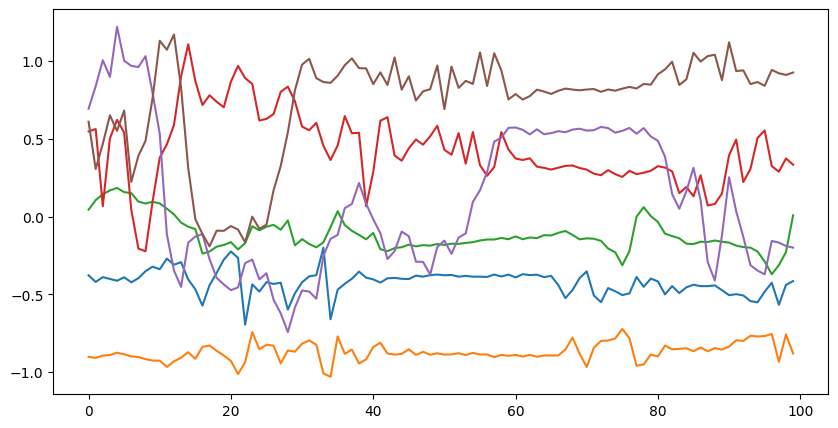

In [5]:
root = "/niddk-data-central/iWatch/pre_processed_seg/HW/10s_train.h5"
import h5py
import random

idx = random.randint(0, 10000)
print('the index is', idx)

with h5py.File(root, "r") as f:
    tmp_sample = f['x'][idx]  # (100, 3)
    print('the index is', idx)  
    tmp_label = 'sitting' if f['y'][idx] == 0 else 'non-sitting' 
    print('the sample label is', tmp_label)

# plot tmp_sample   
import matplotlib.pyplot as plt
import numpy as np

# plot
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.plot(tmp_sample[:, i], label=f'Variable {i+1}')


In [1]:
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(0)

# Dummy data
bs = 2
nvar = 3
num_patches = 4
patch_size = 5

pred = torch.randn(bs, nvar, num_patches, patch_size)
target = torch.randn(bs, nvar, num_patches, patch_size)

# Manual per-sample MSE
squared_error = (pred - target) ** 2  # shape: [bs, nvar, num_patches, patch_size]
manual_loss = squared_error.mean(dim=[1, 2, 3])  # shape: [bs]

# Flatten all dimensions except batch
pred_flat = pred.view(bs, -1)
target_flat = target.view(bs, -1)

# nn.MSELoss with reduction='none' gives per-element loss, so we compute manually
mse = nn.MSELoss(reduction='none')
elementwise_loss = mse(pred_flat, target_flat)  # shape: [bs, total_elements]
mean_loss = elementwise_loss.mean(dim=1)  # average across all elements per batch

# nn.MSELoss with reduction='mean' on entire tensor (for global average)
global_mse = nn.MSELoss(reduction='mean')(pred, target)

print("Manual loss per sample:   ", manual_loss)
print("nn.MSELoss per sample:    ", mean_loss)
print("Global nn.MSELoss (mean): ", global_mse)


Manual loss per sample:    tensor([1.8261, 2.5311])
nn.MSELoss per sample:     tensor([1.8261, 2.5311])
Global nn.MSELoss (mean):  tensor(2.1786)


In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np

class RandomDataset(Dataset):
    def __init__(self, length=4):
        self.length = length
        self.data = range(100)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.length


In [2]:
from torch.utils.data import DataLoader

dataset = RandomDataset()
dataloader = DataLoader(dataset, batch_size=2, num_workers=2)

for epoch in range(3):
    print(f'\nEpoch {epoch}')
    for batch in dataloader:
        print(batch)



Epoch 0
tensor([0, 1])
tensor([2, 3])

Epoch 1
tensor([0, 1])
tensor([2, 3])

Epoch 2
tensor([0, 1])
tensor([2, 3])


In [ ]:
import torch
from torch.utils.data import IterableDataset, get_worker_info

class RandomIterableDataset(IterableDataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.data = range(num_samples)

    def __iter__(self):
        worker_info = get_worker_info()
        if worker_info is None:
            # Single worker
            iter_start = 0
            iter_end = self.num_samples
        else:
            # Multiple workers
            per_worker = int(self.num_samples / worker_info.num_workers)
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            # Last worker may take the remainder
            if worker_id == worker_info.num_workers - 1:
                iter_end = self.num_samples
            else:
                iter_end = iter_start + per_worker

        for i in range(iter_start, iter_end):
            yield self.data[i]



# Instantiate the dataset
dataset = RandomIterableDataset(num_samples=20)

In [37]:
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=5, num_workers=2)

# Iterate over the DataLoader
for epoch in range(3):
    print(f"\nEpoch {epoch}")
    for batch in dataloader:
        print(batch)


Epoch 0
tensor([0, 1, 2, 3, 4])
tensor([10, 11, 12, 13, 14])
tensor([5, 6, 7, 8, 9])
tensor([15, 16, 17, 18, 19])

Epoch 1
tensor([0, 1, 2, 3, 4])
tensor([10, 11, 12, 13, 14])
tensor([5, 6, 7, 8, 9])
tensor([15, 16, 17, 18, 19])

Epoch 2
tensor([0, 1, 2, 3, 4])
tensor([10, 11, 12, 13, 14])
tensor([5, 6, 7, 8, 9])
tensor([15, 16, 17, 18, 19])


In [38]:
import random
import torch
from torch.utils.data import IterableDataset

class BufferedShuffleDataset(IterableDataset):
    def __init__(self, dataset, buffer_size):
        super().__init__()
        self.dataset = dataset
        self.buffer_size = buffer_size

    def __iter__(self):
        buffer = []
        iterator = iter(self.dataset)
        try:
            for _ in range(self.buffer_size):
                buffer.append(next(iterator))
        except StopIteration:
            pass  # In case the dataset has fewer items than the buffer size

        while buffer:
            try:
                item = next(iterator)
                idx = random.randint(0, len(buffer) - 1)
                yield buffer[idx]
                buffer[idx] = item
            except StopIteration:
                break

        while buffer:
            yield buffer.pop(random.randint(0, len(buffer) - 1))


In [45]:
base_dataset = dataset
shuffled_dataset = BufferedShuffleDataset(base_dataset, buffer_size=10)


In [46]:
# Create a DataLoader
shuffle_dataloader = DataLoader(shuffled_dataset, batch_size=5, num_workers=2)

# Iterate over the DataLoader
for epoch in range(3):
    print(f"\nEpoch {epoch}")
    for batch in shuffle_dataloader:
        print(batch)


Epoch 0
tensor([8, 7, 9, 1, 0])
tensor([13, 11, 15, 14, 19])
tensor([5, 2, 6, 3, 4])
tensor([17, 18, 10, 12, 16])

Epoch 1
tensor([7, 5, 4, 6, 3])
tensor([17, 14, 19, 15, 18])
tensor([2, 9, 8, 1, 0])
tensor([12, 16, 10, 13, 11])

Epoch 2
tensor([4, 0, 9, 1, 2])
tensor([12, 10, 18, 14, 19])
tensor([5, 6, 3, 8, 7])
tensor([13, 11, 16, 15, 17])
